# DINOv2 for Semantic Correspondence

Evaluating DINOv2 on SPair-71k dataset.

# Environment Setup and Data Loading


## Environment Setup

In [1]:
# Detect if running in Google Colab or locally
import sys
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")
except ImportError:
    IN_COLAB = False
    print("Running in Local environment")

Running in Google Colab environment


## Mount Drive and Setup Paths

In [2]:
# Mount Google Drive (Colab) or set local path
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_ROOT = Path('/content/drive/MyDrive')
    LOCAL_ROOT = Path('/content')
    !pip install -q torch torchvision timm tqdm scikit-image matplotlib opencv-python pandas
else:
    print('Running locally')
    DRIVE_ROOT = Path('./SemanticCorrespondence').resolve()
    LOCAL_ROOT = DRIVE_ROOT

DRIVE_ROOT.mkdir(exist_ok=True, parents=True)
print(f"Drive: {DRIVE_ROOT}")
print(f"Local: {LOCAL_ROOT}")

Mounted at /content/drive
Drive: /content/drive/MyDrive
Local: /content


## Data Loading

In [3]:
import zipfile
import shutil
import time

def setup_optimized_dataset():
    """Extract SPair-71k from Drive to local storage for faster access."""
    if IN_COLAB:
        drive_zip_path = DRIVE_ROOT / 'SPair-71k.zip'
        local_dataset_path = LOCAL_ROOT / 'SPair-71k'

        # Check if already extracted
        if local_dataset_path.exists():
            expected_dirs = ['JPEGImages', 'PairAnnotation']
            if all((local_dataset_path / d).exists() for d in expected_dirs):
                print(f"Found at: {local_dataset_path}")
                num_images = len(list((local_dataset_path / 'JPEGImages').glob('*/*.jpg')))
                return local_dataset_path
            else:
                print("Incomplete extraction, re-extracting...")
                shutil.rmtree(local_dataset_path)

        # Check if zip exists
        if not drive_zip_path.exists():
            raise FileNotFoundError(
                f"Dataset zip not found at: {drive_zip_path}\n"
                f"Please upload SPair-71k.zip to your Google Drive"
            )

        # Extract
        zip_size_gb = drive_zip_path.stat().st_size / (1024**3)
        print(f"Source: {drive_zip_path}")
        print(f"Size: {zip_size_gb:.2f} GB")
        print(f"Destination: {local_dataset_path}")

        start_time = time.time()
        with zipfile.ZipFile(drive_zip_path, 'r') as zip_ref:
            total_files = len(zip_ref.namelist())
            print(f"Files to extract: {total_files:,}")
            zip_ref.extractall(LOCAL_ROOT)

        elapsed = time.time() - start_time
        print(f"Extracted in {elapsed:.1f}s")

        if local_dataset_path.exists():
            num_images = len(list((local_dataset_path / 'JPEGImages').glob('*/*.jpg')))
            return local_dataset_path
        else:
            raise RuntimeError("Extraction failed")
    else:
        local_path = DRIVE_ROOT / 'SPair-71k'
        if not local_path.exists():
            raise FileNotFoundError(f"Dataset not found at: {local_path}")
        print(f"Dataset at: {local_path}")
        return local_path

DATASET_PATH = setup_optimized_dataset()
print(f"Using: {DATASET_PATH}")

Source: /content/drive/MyDrive/SPair-71k.zip
Size: 0.26 GB
Destination: /content/SPair-71k
Files to extract: 147,396
Extracted in 30.7s
Using: /content/SPair-71k


## Clone DINOv2

In [4]:
# Clone DINOv2 repository if not present
DINO_PATH = DRIVE_ROOT / 'dinov2'

if not DINO_PATH.exists():
    if IN_COLAB:
        !git clone https://github.com/facebookresearch/dinov2.git {DINO_PATH} --depth 1
    else:
        import subprocess
        subprocess.run(['git', 'clone', 'https://github.com/facebookresearch/dinov2.git', str(DINO_PATH), '--depth', '1'])

if str(DINO_PATH) not in sys.path:
    sys.path.append(str(DINO_PATH))

print(f"DINOv2 path added to sys.path: {DINO_PATH}")

DINOv2 path added to sys.path: /content/drive/MyDrive/dinov2


# Imports and Configuration

## Imports

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import json
import hashlib
import pickle
from datetime import datetime
import random


## Configuration

In [6]:
CONFIG = {
    'backbone_size': 'base',
    'image_size': 224,
    'patch_size': 14,
    'feature_layer': 9,
    'batch_size': 32,
    'max_samples': None,
    'pck_thresholds': [0.05, 0.1, 0.15, 0.2],
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'dataset_path': DATASET_PATH,
    'cache_dir': DRIVE_ROOT / 'eval_cache',
    'results_dir': DRIVE_ROOT / 'results',
    'checkpoint_dir': DRIVE_ROOT / 'checkpoints'
}

FT_CONFIG = {
    'max_train_samples': None,
    'learning_rate': 1e-5,
    'epochs': 5,
    'batch_size': 32,
    'temperature': 0.1,
    'weight_decay': 0.05,
    'label_smoothing': 0.1,
    'warmup_steps': 100,
    'max_grad_norm': 1.0,
    'use_augmentation': True,
    'horizontal_flip_prob': 0.5,
    'color_jitter': 0.2,
    'use_early_stopping': True,
    'patience': 2,
    'min_delta': 0.001,
    'device': CONFIG['device']
}

CONFIG['cache_dir'].mkdir(exist_ok=True, parents=True)
CONFIG['results_dir'].mkdir(exist_ok=True, parents=True)
CONFIG['checkpoint_dir'].mkdir(exist_ok=True, parents=True)

print(f"Device: {CONFIG['device']}")

Device: cuda


## Dataset

In [7]:
class SPairDataset(Dataset):
    """SPair-71k dataset for semantic correspondence."""

    def __init__(self, root_dir, split='test', image_size=224, max_samples=None, augment=False):
        self.root_dir = Path(root_dir)
        self.split = split
        self.image_size = image_size
        self.augment = augment and (split == 'train')  # Only augment training data

        # Map split names to directory names
        split_map = {'train': 'trn', 'val': 'val', 'test': 'test'}
        split_name = split_map.get(split, split)

        # Load annotations directly from PairAnnotation directory
        anno_dir = self.root_dir / 'PairAnnotation' / split_name

        if not anno_dir.exists():
            raise FileNotFoundError(f"Annotation directory not found: {anno_dir}")

        # Scan all JSON files
        print(f"Loading annotations from {anno_dir}...")
        self.annotation_files = sorted(list(anno_dir.glob('*.json')))

        if max_samples:
            self.annotation_files = self.annotation_files[:max_samples]

        # Pre-load annotations to validate and count categories
        self.annotations = []
        category_count = {}

        for json_file in tqdm(self.annotation_files, desc="Validating annotations"):
            try:
                with open(json_file, 'r') as f:
                    anno = json.load(f)

                # Validate required fields exist
                src_img = anno.get('src_imname', '')
                tgt_img = anno.get('trg_imname', '') or anno.get('tgt_imname', '')
                category = anno.get('category', '')

                if not all([src_img, tgt_img, category]):
                    continue

                # Check images exist
                src_path = self.root_dir / 'JPEGImages' / category / src_img
                tgt_path = self.root_dir / 'JPEGImages' / category / tgt_img

                if src_path.exists() and tgt_path.exists():
                    self.annotations.append({
                        'json_path': json_file,
                        'src_img': src_img,
                        'tgt_img': tgt_img,
                        'category': category
                    })
                    category_count[category] = category_count.get(category, 0) + 1
            except Exception as e:
                continue

        print(f"{len(self.annotations)} pairs")

        # Setup augmentation transforms
        if self.augment:
            self.color_jitter = T.ColorJitter(
                brightness=FT_CONFIG['color_jitter'],
                contrast=FT_CONFIG['color_jitter'],
                saturation=FT_CONFIG['color_jitter'],
                hue=FT_CONFIG['color_jitter'] / 2
            )

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Load a single image pair with keypoints.
        """
        anno_info = self.annotations[idx]

        # Load annotation JSON
        with open(anno_info['json_path'], 'r') as f:
            anno = json.load(f)

        # Load images
        src_path = self.root_dir / 'JPEGImages' / anno_info['category'] / anno_info['src_img']
        tgt_path = self.root_dir / 'JPEGImages' / anno_info['category'] / anno_info['tgt_img']

        src_img = Image.open(src_path).convert('RGB')
        tgt_img = Image.open(tgt_path).convert('RGB')

        src_orig_size = src_img.size  # (width, height)
        tgt_orig_size = tgt_img.size

        # Load keypoints
        src_kps = np.array(anno['src_kps'], dtype=np.float32)
        tgt_kps = np.array(anno.get('trg_kps', anno.get('tgt_kps')), dtype=np.float32)

        # Apply augmentation (horizontal flip with keypoint adjustment)
        do_flip = self.augment and random.random() < FT_CONFIG['horizontal_flip_prob']

        if do_flip:
            # Flip images
            src_img = src_img.transpose(Image.FLIP_LEFT_RIGHT)
            tgt_img = tgt_img.transpose(Image.FLIP_LEFT_RIGHT)

            # Flip keypoint x-coordinates
            valid_src = src_kps[:, 0] >= 0
            valid_tgt = tgt_kps[:, 0] >= 0
            src_kps[valid_src, 0] = src_orig_size[0] - 1 - src_kps[valid_src, 0]
            tgt_kps[valid_tgt, 0] = tgt_orig_size[0] - 1 - tgt_kps[valid_tgt, 0]

        # Apply color jitter (doesn't affect keypoints)
        if self.augment:
            src_img = self.color_jitter(src_img)
            tgt_img = self.color_jitter(tgt_img)

        # Resize images
        src_img = src_img.resize((self.image_size, self.image_size), Image.BILINEAR)
        tgt_img = tgt_img.resize((self.image_size, self.image_size), Image.BILINEAR)

        # Scale keypoints to resized image coordinates
        src_kps[:, 0] = src_kps[:, 0] * self.image_size / src_orig_size[0]
        src_kps[:, 1] = src_kps[:, 1] * self.image_size / src_orig_size[1]
        tgt_kps[:, 0] = tgt_kps[:, 0] * self.image_size / tgt_orig_size[0]
        tgt_kps[:, 1] = tgt_kps[:, 1] * self.image_size / tgt_orig_size[1]

        # Mark valid keypoints (both coordinates >= 0 means visible)
        valid = np.array([
            (s[0] >= 0 and s[1] >= 0 and t[0] >= 0 and t[1] >= 0)
            for s, t in zip(src_kps, tgt_kps)
        ], dtype=bool)

        # Convert to tensors
        src_tensor = self._to_tensor(src_img)
        tgt_tensor = self._to_tensor(tgt_img)

        return {
            'src_img': src_tensor,
            'tgt_img': tgt_tensor,
            'src_kps': torch.from_numpy(src_kps),
            'tgt_kps': torch.from_numpy(tgt_kps),
            'valid': torch.from_numpy(valid),
            'category': anno_info['category']
        }

    def _to_tensor(self, img):
        """
        Convert PIL image to normalized tensor.

        Uses ImageNet normalization (same as DINOv2 pretraining):
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
        """
        tensor = torch.tensor(np.array(img)).permute(2, 0, 1).float() / 255.0
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

## Load DINOv2

In [8]:
def load_dinov2(size='base', device='cuda'):
    """Load DINOv2 model."""
    model_names = {
        'small': 'dinov2_vits14',
        'base': 'dinov2_vitb14',
        'large': 'dinov2_vitl14'
    }

    model = torch.hub.load('facebookresearch/dinov2', model_names[size], trust_repo=True)
    model = model.to(device)
    model.eval()
    print(f"Model loaded ({sum(p.numel() for p in model.parameters()):,} parameters)")
    return model

# Load the backbone model
backbone = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 250MB/s]


Model loaded (86,580,480 parameters)


## Feature Extractor

In [9]:
class FeatureExtractor:
    """Extract features from DINOv2."""

    def __init__(self, model, patch_size=14, device='cuda'):
        self.model = model
        self.patch_size = patch_size
        self.device = device
        self.hook_output = None

    def _hook(self, module, input, output):
        """Forward hook to capture intermediate layer output."""
        self.hook_output = output

    def extract(self, img, layer_idx=None):
        """
        Extract features from the model.
        """
        B, C, H, W = img.shape

        # Ensure image dimensions are divisible by patch size
        H_adj = (H // self.patch_size) * self.patch_size
        W_adj = (W // self.patch_size) * self.patch_size
        if H != H_adj or W != W_adj:
            img = F.interpolate(img, size=(H_adj, W_adj), mode='bilinear', align_corners=False)

        # Register hook if extracting from intermediate layer
        hook = None
        if layer_idx is not None:
            hook = self.model.blocks[layer_idx].register_forward_hook(self._hook)

        # Forward pass through the model
        out = self.model.forward_features(img)

        # Get features from the appropriate source
        if layer_idx is not None and self.hook_output is not None:
            # Use intermediate layer output, remove CLS token
            features = self.hook_output[:, 1:]
            hook.remove()
            self.hook_output = None
        else:
            # Use final normalized patch tokens
            features = out['x_norm_patchtokens']

        # Reshape from [B, N_patches, D] to [B, H_feat, W_feat, D]
        H_feat = H_adj // self.patch_size
        W_feat = W_adj // self.patch_size
        D = features.shape[-1]

        features = features.reshape(B, H_feat, W_feat, D)

        # L2 normalize features (crucial for cosine similarity matching)
        features = F.normalize(features, p=2, dim=-1)

        return features

## Correspondence Finding

In [10]:
def find_correspondences(src_feats, tgt_feats, src_kps_list, patch_size=14):
    """Find correspondences using nearest neighbor."""
    B, H, W, D = src_feats.shape
    pred_kps_list = []

    for b in range(B):
        src_kps = src_kps_list[b]  # [N_kps, 2] in pixel coordinates
        num_kps = src_kps.shape[0]

        # Convert pixel coordinates to feature grid coordinates
        # pixel_coord / patch_size gives grid position
        src_kps_grid = (src_kps / patch_size).long()
        src_kps_grid[:, 0] = torch.clamp(src_kps_grid[:, 0], 0, W - 1)  # x -> column
        src_kps_grid[:, 1] = torch.clamp(src_kps_grid[:, 1], 0, H - 1)  # y -> row

        # Flatten target features for similarity computation
        tgt_flat = tgt_feats[b].reshape(-1, D)  # [H*W, D]

        pred_kps = torch.zeros_like(src_kps)

        for k in range(num_kps):
            x_grid = src_kps_grid[k, 0]  # column
            y_grid = src_kps_grid[k, 1]  # row

            # Get source keypoint's feature vector
            src_vec = src_feats[b, y_grid, x_grid]  # [D]

            # Compute cosine similarity with all target positions
            # (features are L2-normalized, so dot product = cosine similarity)
            similarities = torch.matmul(src_vec, tgt_flat.T)  # [H*W]

            # Find the position with highest similarity
            best_idx = torch.argmax(similarities)
            y_pred = best_idx // W
            x_pred = best_idx % W

            # Convert back to pixel coordinates (center of the predicted patch)
            pred_kps[k, 0] = x_pred * patch_size + patch_size // 2
            pred_kps[k, 1] = y_pred * patch_size + patch_size // 2

        pred_kps_list.append(pred_kps)

    return pred_kps_list

## PCK Metric

In [11]:
def compute_pck(pred_kps, gt_kps, valid, thresholds, img_size):
    """
    Compute Percentage of Correct Keypoints (PCK).

    A keypoint prediction is "correct" if its Euclidean distance from
    the ground truth is less than threshold × image_size.

    Args:
        pred_kps: List of [N, 2] predicted keypoints
        gt_kps: List of [N, 2] ground truth keypoints
        valid: List of [N] boolean validity masks
        thresholds: List of threshold values (e.g., [0.05, 0.1, 0.15, 0.2])
        img_size: Image size for normalization

    Returns:
        dict: {f'PCK@{threshold}': percentage, ...}
    """
    results = {}

    for alpha in thresholds:
        threshold_pixels = alpha * img_size  # Convert to pixel distance
        correct = 0
        total = 0

        for b in range(len(pred_kps)):
            for k in range(len(pred_kps[b])):
                if not valid[b][k]:
                    continue  # Skip invalid keypoints

                # Compute Euclidean distance
                dist = torch.norm(pred_kps[b][k].float() - gt_kps[b][k].float()).item()

                if dist <= threshold_pixels:
                    correct += 1
                total += 1

        pck = (correct / total * 100) if total > 0 else 0.0
        results[f'PCK@{alpha}'] = pck

    return results

## Evaluation Function

In [12]:
def get_cache_key(config, tag=None):
    """Generate a unique cache key based on configuration."""
    key_parts = [
        config['backbone_size'],
        str(config['image_size']),
        str(config['feature_layer']),
        str(config['max_samples'])
    ]
    if tag:
        key_parts.append(tag)
    return f"eval_cache_{'_'.join(key_parts)}.pkl"

def save_evaluation_cache(results, config, tag=None):
    """Save evaluation results to cache."""
    cache_file = config['cache_dir'] / get_cache_key(config, tag)
    cache_data = {
        'predictions': results['predictions'],
        'ground_truth': results['ground_truth'],
        'valid': results['valid'],
        'categories_list': results['categories_list'],
        'config': {k: str(v) for k, v in config.items()},
        'timestamp': datetime.now().isoformat()
    }
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)

def load_evaluation_cache(config, tag=None):
    """Load evaluation results from cache if available."""
    cache_file = config['cache_dir'] / get_cache_key(config, tag)
    if not cache_file.exists():
        return None
    try:
        with open(cache_file, 'rb') as f:
            cache_data = pickle.load(f)

        return cache_data
    except Exception as e:
        print(f"Warning: Cache load failed: {e}")
        return None

def evaluate(model, config, tag=None, use_cache=True, force_recompute=False):
    """
    Evaluate model on the test set.

    Args:
        model: DINOv2 model to evaluate
        config: Configuration dict
        tag: Optional tag for cache file naming
        use_cache: Whether to use cached results
        force_recompute: If True, ignore cache and recompute

    Returns:
        dict with 'overall', 'categories', 'predictions', 'ground_truth', 'valid', etc.
    """
    # Evaluation

    # Try to load from cache
    if use_cache and not force_recompute:
        cache_data = load_evaluation_cache(config, tag)
        if cache_data is not None:
            # Recompute metrics from cached predictions
            all_preds = cache_data['predictions']
            all_gts = cache_data['ground_truth']
            all_valids = cache_data['valid']
            all_cats = cache_data['categories_list']

            pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])

            print("\nOverall Results:")
            for threshold, pck in pck_overall.items():
                print(f"  {threshold}: {pck:.2f}%")

            # NEW: Compute per-image PCK (from cache)
            per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
            for i in range(len(all_preds)):
                res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
                for k, v in res.items():
                    per_image_pck[k].append(v)

            mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}

            print("\nMean Per-Image PCK:")
            for threshold, pck in mean_per_image.items():
                print(f"  {threshold}: {pck:.2f}%")

            # Per-category
            unique_cats = sorted(set(all_cats))
            pck_by_cat = {}
            for cat in unique_cats:
                cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
                cat_preds = [all_preds[i] for i in cat_indices]
                cat_gts = [all_gts[i] for i in cat_indices]
                cat_valids = [all_valids[i] for i in cat_indices]
                if cat_preds:
                    pck_by_cat[cat] = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])

            return {
                'overall': pck_overall,
                'mean_per_image': mean_per_image,
                'per_image_scores': per_image_pck,
                'categories': pck_by_cat,
                'predictions': all_preds,
                'ground_truth': all_gts,
                'valid': all_valids,
                'categories_list': all_cats
            }

    # Run full evaluation
    print("\nRunning full evaluation...")

    dataset = SPairDataset(
        config['dataset_path'],
        split='test',
        image_size=config['image_size'],
        max_samples=config['max_samples']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }

    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)
    extractor = FeatureExtractor(model, config['patch_size'], config['device'])

    model.eval()
    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            src_img = batch['src_img'].to(config['device'])
            tgt_img = batch['tgt_img'].to(config['device'])
            src_kps = [kp.to(config['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(config['device']) for kp in batch['tgt_kps']]
            valid = [v.to(config['device']) for v in batch['valid']]

            # Extract features
            src_feats = extractor.extract(src_img, layer_idx=config['feature_layer'])
            tgt_feats = extractor.extract(tgt_img, layer_idx=config['feature_layer'])

            # Find correspondences
            pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, config['patch_size'])

            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])

    # Compute overall PCK
    pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])

    print("\nOverall Results:")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    # NEW: Compute per-image PCK
    per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
    for i in range(len(all_preds)):
        res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
        for k, v in res.items():
            per_image_pck[k].append(v)

    mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}

    print("\nMean Per-Image PCK:")
    for threshold, pck in mean_per_image.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Compute per-category PCK
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}

    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]

        if cat_preds:
            cat_pck = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: {cat_pck['PCK@0.1']:.1f}%")

    results = {
        'overall': pck_overall,
        'mean_per_image': mean_per_image,
        'per_image_scores': per_image_pck,
        'categories': pck_by_cat,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats
    }

    # Save to cache
    if use_cache:
        save_evaluation_cache(results, config, tag)

    return results

## Baseline Evaluation

In [13]:
# Evaluate the pre-trained model as baseline

results_baseline = evaluate(backbone, CONFIG, tag='baseline')


Overall Results:
  PCK@0.05: 30.95%
  PCK@0.1: 51.88%
  PCK@0.15: 63.17%
  PCK@0.2: 70.97%

Mean Per-Image PCK:
  PCK@0.05: 29.04%
  PCK@0.1: 49.21%
  PCK@0.15: 60.24%
  PCK@0.2: 67.98%


## Visualization

Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:01<00:00, 10809.07it/s]


12234 pairs


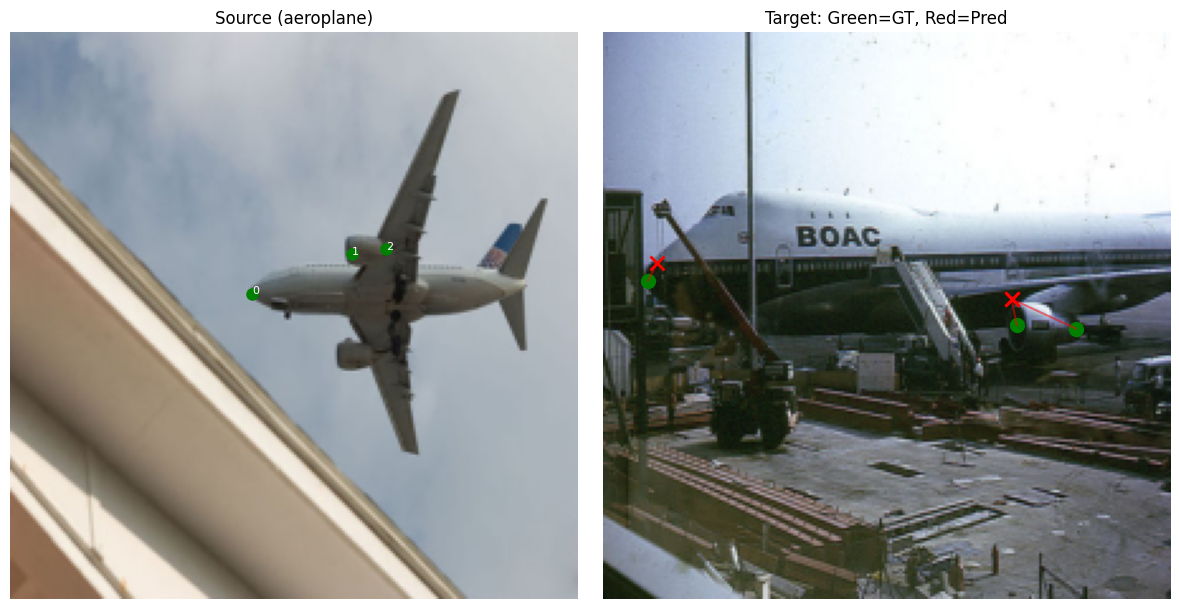

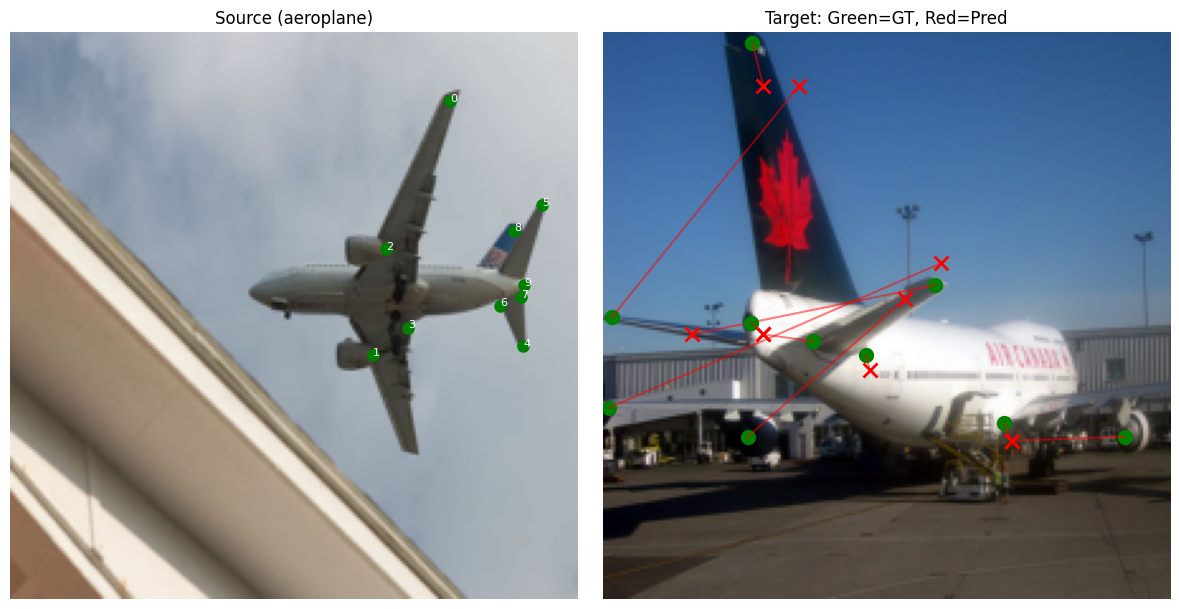

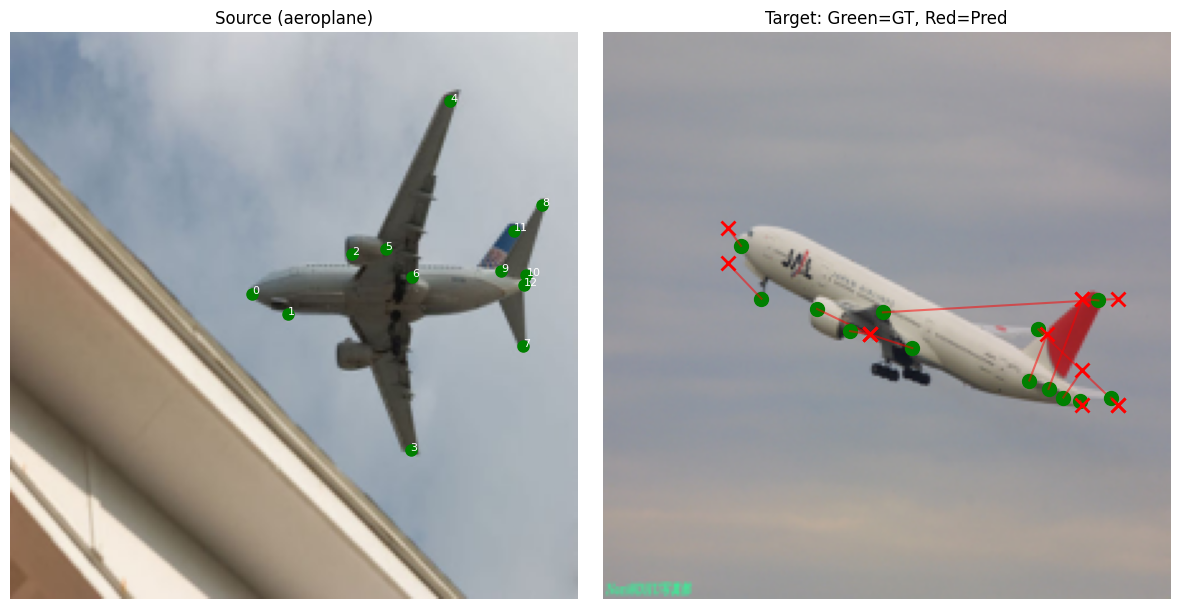

In [14]:
def visualize_correspondence(dataset, predictions, ground_truth, idx):
    """
    Visualize correspondence predictions vs ground truth for a single sample.

    Shows:
    - Left: Source image with source keypoints (green)
    - Right: Target image with predicted (red) and ground truth (green) keypoints
    """
    sample = dataset[idx]
    pred_kps = predictions[idx]
    gt_kps = ground_truth[idx]
    valid = sample['valid']

    # Denormalize images for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    src_img = (sample['src_img'] * std + mean).permute(1, 2, 0).numpy()
    tgt_img = (sample['tgt_img'] * std + mean).permute(1, 2, 0).numpy()
    src_img = np.clip(src_img, 0, 1)
    tgt_img = np.clip(tgt_img, 0, 1)

    src_kps = sample['src_kps'].numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Source image
    axes[0].imshow(src_img)
    axes[0].set_title(f"Source ({sample['category']})")

    # Target image
    axes[1].imshow(tgt_img)
    axes[1].set_title(f"Target: Green=GT, Red=Pred")

    # Plot keypoints
    for k in range(len(src_kps)):
        if not valid[k]:
            continue

        # Source keypoint
        axes[0].plot(src_kps[k, 0], src_kps[k, 1], 'go', markersize=8)
        axes[0].annotate(str(k), (src_kps[k, 0], src_kps[k, 1]), fontsize=8, color='white')

        # Ground truth keypoint (green)
        gt_pt = gt_kps[k].numpy()
        axes[1].plot(gt_pt[0], gt_pt[1], 'go', markersize=10)

        # Predicted keypoint (red)
        pred_pt = pred_kps[k].numpy()
        axes[1].plot(pred_pt[0], pred_pt[1], 'rx', markersize=10, markeredgewidth=2)

        # Line connecting prediction to ground truth
        axes[1].plot([gt_pt[0], pred_pt[0]], [gt_pt[1], pred_pt[1]], 'r-', alpha=0.5)

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Load dataset for visualization
viz_dataset = SPairDataset(
    CONFIG['dataset_path'],
    split='test',
    image_size=CONFIG['image_size'],
    max_samples=CONFIG['max_samples']
)



# Visualize a few examples
for i in range(min(3, len(viz_dataset))):
    visualize_correspondence(viz_dataset, results_baseline['predictions'], results_baseline['ground_truth'], i)

# Part 2: Fine-Tuning

## Layer Analysis

In [15]:
def correspondence_loss(src_feats, tgt_feats, src_kps, tgt_kps, valid, temperature=0.1, label_smoothing=0.0):
    """
    Simple Cross-Entropy Loss for Semantic Correspondence.

    This loss treats correspondence as classification: for each source keypoint,
    predict which of the 256 (16×16) target positions it corresponds to.

    Args:
        src_feats: [B, H, W, D] Source image features (L2-normalized)
        tgt_feats: [B, H, W, D] Target image features (L2-normalized)
        src_kps: List of [N, 2] source keypoint coordinates for each batch item
        tgt_kps: List of [N, 2] target keypoint coordinates for each batch item
        valid: List of [N] boolean masks for valid keypoints
        temperature: Softmax temperature (lower = sharper distribution)
        label_smoothing: Amount of label smoothing (0 = no smoothing)

    Returns:
        loss: Scalar loss value
    """
    B, H, W, D = src_feats.shape
    patch_size = CONFIG['patch_size']

    total_loss = 0.0
    num_valid_samples = 0

    for b in range(B):
        #
        # Get valid keypoints for this batch item
        #
        mask = valid[b]  # [N] boolean mask
        if not mask.any():
            continue  # Skip if no valid keypoints

        src_kp = src_kps[b][mask]  # [N_valid, 2] - valid source keypoints
        tgt_kp = tgt_kps[b][mask]  # [N_valid, 2] - valid target keypoints

        #
        # Convert pixel coordinates to grid coordinates
        #
        # Pixel coord (0-223) -> Grid coord (0-15)
        # We divide by patch_size (14) and clamp to valid range

        src_grid = (src_kp / patch_size).long()  # [N_valid, 2]
        tgt_grid = (tgt_kp / patch_size).long()  # [N_valid, 2]

        # Clamp to valid grid range [0, 15]
        src_grid[:, 0] = torch.clamp(src_grid[:, 0], 0, W - 1)  # x -> column
        src_grid[:, 1] = torch.clamp(src_grid[:, 1], 0, H - 1)  # y -> row
        tgt_grid[:, 0] = torch.clamp(tgt_grid[:, 0], 0, W - 1)
        tgt_grid[:, 1] = torch.clamp(tgt_grid[:, 1], 0, H - 1)

        #
        # Flatten feature maps for efficient computation
        #
        # Reshape from [H, W, D] to [H*W, D] for matrix multiplication
        src_flat = src_feats[b].reshape(-1, D)  # [256, 768]
        tgt_flat = tgt_feats[b].reshape(-1, D)  # [256, 768]

        #
        # Convert 2D grid coordinates to 1D indices
        #
        # Index = row * width + column = y * W + x
        src_indices = src_grid[:, 1] * W + src_grid[:, 0]  # [N_valid]
        tgt_indices = tgt_grid[:, 1] * W + tgt_grid[:, 0]  # [N_valid]

        #
        # Extract source keypoint features
        #
        src_vecs = src_flat[src_indices]  # [N_valid, 768]

        #
        # Compute similarity scores (logits)
        #
        # For each source keypoint, compute similarity to ALL target positions
        # Since features are L2-normalized, dot product = cosine similarity
        # Divide by temperature to control sharpness of distribution

        logits = torch.matmul(src_vecs, tgt_flat.T) / temperature  # [N_valid, 256]

        #
        # Apply cross-entropy loss
        #
        # target_indices tells us which of the 256 positions is correct
        # Cross-entropy encourages high probability for correct position

        loss = F.cross_entropy(
            logits,           # [N_valid, 256] - predicted scores
            tgt_indices,      # [N_valid] - ground truth class (position)
            label_smoothing=label_smoothing
        )

        total_loss += loss
        num_valid_samples += 1

    # Average loss across batch items
    if num_valid_samples > 0:
        return total_loss / num_valid_samples
    else:
        return torch.tensor(0.0, device=src_feats.device, requires_grad=True)

print(" Loss function defined")

 Loss function defined


## Baseline Evaluation

In [16]:
def unfreeze_last_n_blocks(model, n_blocks=1):
    """
    Unfreeze only the last N transformer blocks for fine-tuning.

    This is a key strategy to prevent overfitting:
    - Early layers capture low-level features (edges, textures) - keep frozen
    - Later layers capture high-level semantics - fine-tune these

    Args:
        model: DINOv2 model
        n_blocks: Number of blocks to unfreeze from the end

    Returns:
        model with updated requires_grad settings
    """
    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Get total number of transformer blocks
    total_blocks = len(model.blocks)
    start_idx = total_blocks - n_blocks

    print(f"Model has {total_blocks} transformer blocks")
    print(f"Unfreezing blocks {start_idx} to {total_blocks-1}")

    # Unfreeze the last N blocks
    for i in range(start_idx, total_blocks):
        for param in model.blocks[i].parameters():
            param.requires_grad = True

    # Also unfreeze the final layer norm (helps with output quality)
    if hasattr(model, 'norm'):
        for param in model.norm.parameters():
            param.requires_grad = True
        print("Also unfreezing final norm layer")

    # Count parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"\nTrainable: {trainable:,} / {total:,} ({100*trainable/total:.1f}%)")

    return model

## Training Loop

In [17]:
def train_finetune():
    """Fine-tune DINOv2 for correspondence."""
    print("\n" + "=" * 70)

    # Load fresh model
    model = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

    # Unfreeze only last N blocks
    model = unfreeze_last_n_blocks(model, FT_CONFIG['unfreeze_last_n_blocks'])

    # Load datasets
    print("Loading datasets")
    train_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='train',
        image_size=CONFIG['image_size'],
        max_samples=FT_CONFIG['max_train_samples'],
        augment=FT_CONFIG['use_augmentation']
    )

    val_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='val',
        image_size=CONFIG['image_size'],
        augment=False  # No augmentation for validation
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch]
        }

    train_loader = DataLoader(
        train_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2, # Increased from 0 to speed up data loading
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=FT_CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2 # Increased from 0
    )

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=FT_CONFIG['learning_rate'],
        weight_decay=FT_CONFIG['weight_decay']
    )

    # Learning rate scheduler with warmup
    total_steps = len(train_loader) * FT_CONFIG['epochs']
    warmup_steps = FT_CONFIG['warmup_steps']

    def lr_lambda(step):
        if step < warmup_steps:
            return float(step) / float(max(1, warmup_steps))
        return max(0.1, 1.0 - (step - warmup_steps) / (total_steps - warmup_steps))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Feature extractor
    extractor = FeatureExtractor(model, CONFIG['patch_size'], CONFIG['device'])

    # Training tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"Training {FT_CONFIG['epochs']} epochs")

    for epoch in range(FT_CONFIG['epochs']):
        # Training ===
        model.train()
        epoch_train_loss = []

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Train]")
        for batch in pbar:
            optimizer.zero_grad()

            src_img = batch['src_img'].to(CONFIG['device'])
            tgt_img = batch['tgt_img'].to(CONFIG['device'])
            src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
            valid = [v.to(CONFIG['device']) for v in batch['valid']]

            # Extract features (use None for final layer to ensure gradient flow)
            src_feats = extractor.extract(src_img, layer_idx=None)
            tgt_feats = extractor.extract(tgt_img, layer_idx=None)

            # Compute loss
            loss = correspondence_loss(
                src_feats, tgt_feats,
                src_kps, tgt_kps, valid,
                temperature=FT_CONFIG['temperature'],
                label_smoothing=FT_CONFIG['label_smoothing']
            )

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                filter(lambda p: p.requires_grad, model.parameters()),
                FT_CONFIG['max_grad_norm']
            )

            optimizer.step()
            scheduler.step()

            epoch_train_loss.append(loss.item())
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_train_loss = sum(epoch_train_loss) / len(epoch_train_loss)
        train_losses.append(avg_train_loss)

        # Validation ===
        model.eval()
        epoch_val_loss = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{FT_CONFIG['epochs']} [Val]", leave=False):
                src_img = batch['src_img'].to(CONFIG['device'])
                tgt_img = batch['tgt_img'].to(CONFIG['device'])
                src_kps = [kp.to(CONFIG['device']) for kp in batch['src_kps']]
                tgt_kps = [kp.to(CONFIG['device']) for kp in batch['tgt_kps']]
                valid = [v.to(CONFIG['device']) for v in batch['valid']]

                src_feats = extractor.extract(src_img, layer_idx=None)
                tgt_feats = extractor.extract(tgt_img, layer_idx=None)

                loss = correspondence_loss(
                    src_feats, tgt_feats,
                    src_kps, tgt_kps, valid,
                    temperature=FT_CONFIG['temperature'],
                    label_smoothing=0.0  # No smoothing for validation
                )
                epoch_val_loss.append(loss.item())

        avg_val_loss = sum(epoch_val_loss) / len(epoch_val_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")

        # Early Stopping ===
        if FT_CONFIG['use_early_stopping']:
            if avg_val_loss < best_val_loss - FT_CONFIG['min_delta']:
                best_val_loss = avg_val_loss
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                print(f"  New best (val={best_val_loss:.4f})")
            else:
                patience_counter += 1
                print(f"  No improvement ({patience_counter}/{FT_CONFIG['patience']})")

                if patience_counter >= FT_CONFIG['patience']:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model restored")

    print("\n" + "=" * 70)
    print("Training done")

    return model, {'train': train_losses, 'val': val_losses}

## Run Fine-Tuning

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded (86,580,480 parameters)
Model has 12 transformer blocks
Unfreezing blocks 11 to 11
Also unfreezing final norm layer

Trainable: 7,090,944 / 86,580,480 (8.2%)
Loading datasets
Loading annotations from /content/SPair-71k/PairAnnotation/trn...


Validating annotations: 100%|██████████| 53340/53340 [00:03<00:00, 13379.39it/s]


53340 pairs
Loading annotations from /content/SPair-71k/PairAnnotation/val...


Validating annotations: 100%|██████████| 5384/5384 [00:00<00:00, 12375.45it/s]


5384 pairs
Training 5 epochs


Epoch 1/5 [Train]: 100%|██████████| 1667/1667 [45:49<00:00,  1.65s/it, loss=2.4293]


Epoch 1: Train=2.8917, Val=2.6341
  New best (val=2.6341)


Epoch 2/5 [Train]: 100%|██████████| 1667/1667 [46:05<00:00,  1.66s/it, loss=2.0467]


Epoch 2: Train=2.1470, Val=2.7754
  No improvement (1/2)


Epoch 3/5 [Train]: 100%|██████████| 1667/1667 [45:51<00:00,  1.65s/it, loss=1.5947]


Epoch 3: Train=1.8286, Val=2.9672
  No improvement (2/2)
Early stopping at epoch 3
Best model restored

Training done


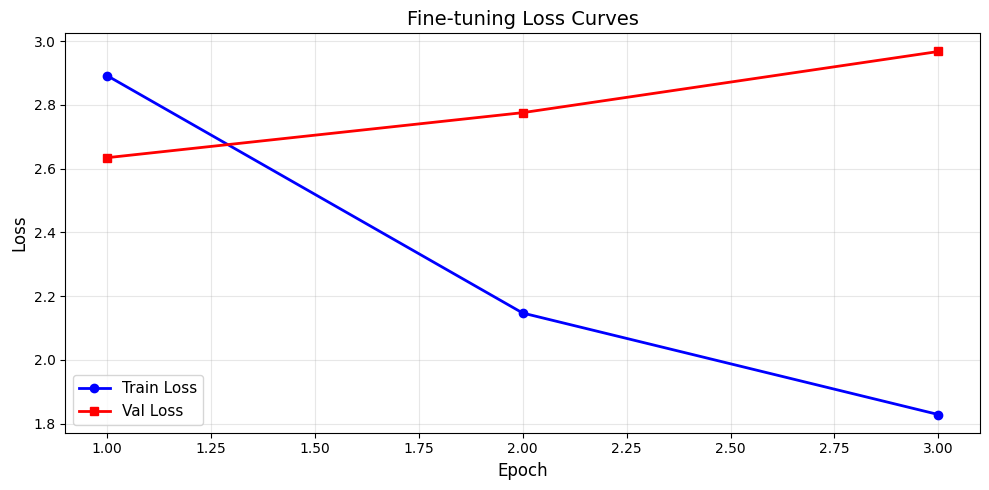


Final Train Loss: 1.8286
Final Val Loss: 2.9672
Best Val Loss: 2.6341


In [18]:
if 'unfreeze_last_n_blocks' not in FT_CONFIG:
    FT_CONFIG['unfreeze_last_n_blocks'] = 1  # Unfreeze the last transformer block

# Run fine-tuning
finetuned_model, loss_history = train_finetune()

# Plot training curves
fig, ax = plt.subplots(figsize=(10, 5))

epochs_range = range(1, len(loss_history['train']) + 1)
ax.plot(epochs_range, loss_history['train'], 'b-o', label='Train Loss', linewidth=2)
ax.plot(epochs_range, loss_history['val'], 'r-s', label='Val Loss', linewidth=2)

ax.set_title("Fine-tuning Loss Curves", fontsize=14)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {loss_history['train'][-1]:.4f}")
print(f"Final Val Loss: {loss_history['val'][-1]:.4f}")
print(f"Best Val Loss: {min(loss_history['val']):.4f}")

## Evaluate Fine-Tuned Model

In [19]:
# Note: We evaluate using the FINAL layer (same as training) not layer 9
# This is important for consistency

# Create a modified config for finetuned evaluation
FT_EVAL_CONFIG = CONFIG.copy()
FT_EVAL_CONFIG['feature_layer'] = None  # Use final layer output

print("Evaluating")
results_finetuned = evaluate(finetuned_model, FT_EVAL_CONFIG, tag='finetuned', use_cache=False)

Evaluating

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:00<00:00, 13505.56it/s]


12234 pairs


Evaluating: 100%|██████████| 383/383 [08:22<00:00,  1.31s/it]



Overall Results:
  PCK@0.05: 49.41%
  PCK@0.1: 70.28%
  PCK@0.15: 79.36%
  PCK@0.2: 85.06%

Mean Per-Image PCK:
  PCK@0.05: 47.80%
  PCK@0.1: 68.15%
  PCK@0.15: 77.36%
  PCK@0.2: 83.18%

Per-Category Results (PCK@0.1):
  aeroplane: 71.8%
  bicycle: 69.7%
  bird: 87.0%
  boat: 56.8%
  bottle: 57.4%
  bus: 70.2%
  car: 66.2%
  cat: 82.1%
  chair: 53.6%
  cow: 80.1%
  dog: 78.4%
  horse: 80.2%
  motorbike: 70.5%
  person: 72.2%
  pottedplant: 61.2%
  sheep: 74.2%
  train: 71.1%
  tvmonitor: 60.0%


## Compare Results

In [20]:

# Get PCK scores
base_pck = [results_baseline['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
ft_pck = [results_finetuned['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]

# Create comparison table
df_compare = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'Baseline': base_pck,
    'Fine-tuned': ft_pck
})
df_compare['Improvement'] = df_compare['Fine-tuned'] - df_compare['Baseline']
df_compare['Relative %'] = (df_compare['Improvement'] / df_compare['Baseline'] * 100)

print("\nPCK Comparison:")
print(df_compare.to_string(index=False, float_format='%.2f'))

# Per-category comparison at PCK@0.1
print("Per-Category Comparison (PCK@0.1)")

categories = sorted(results_baseline['categories'].keys())
cat_comparison = []

for cat in categories:
    base_val = results_baseline['categories'][cat].get('PCK@0.1', 0)
    ft_val = results_finetuned['categories'][cat].get('PCK@0.1', 0)
    improvement = ft_val - base_val
    cat_comparison.append({
        'Category': cat,
        'Baseline': base_val,
        'Fine-tuned': ft_val,
        'Improvement': improvement
    })

df_cat = pd.DataFrame(cat_comparison)
print(df_cat.to_string(index=False, float_format='%.1f'))

# Summary
improved_cats = sum(1 for c in cat_comparison if c['Improvement'] > 0)
avg_improvement = df_compare[df_compare['Threshold'] == 0.1]['Improvement'].values[0]

print(f"Baseline PCK@0.1:   {results_baseline['overall']['PCK@0.1']:.2f}%")
print(f"Fine-tuned PCK@0.1: {results_finetuned['overall']['PCK@0.1']:.2f}%")
print(f"Improvement:        {avg_improvement:+.2f}%")
print(f"Categories improved: {improved_cats}/{len(categories)}")


PCK Comparison:
 Threshold  Baseline  Fine-tuned  Improvement  Relative %
      0.05     30.95       49.41        18.46       59.66
      0.10     51.88       70.28        18.40       35.47
      0.15     63.17       79.36        16.19       25.63
      0.20     70.97       85.06        14.10       19.86
Per-Category Comparison (PCK@0.1)
   Category  Baseline  Fine-tuned  Improvement
  aeroplane      56.8        71.8         15.0
    bicycle      52.9        69.7         16.8
       bird      82.3        87.0          4.7
       boat      36.3        56.8         20.5
     bottle      36.4        57.4         21.1
        bus      39.6        70.2         30.6
        car      42.8        66.2         23.4
        cat      68.3        82.1         13.8
      chair      35.1        53.6         18.4
        cow      63.5        80.1         16.7
        dog      64.3        78.4         14.1
      horse      58.9        80.2         21.2
  motorbike      43.7        70.5         26.9
 

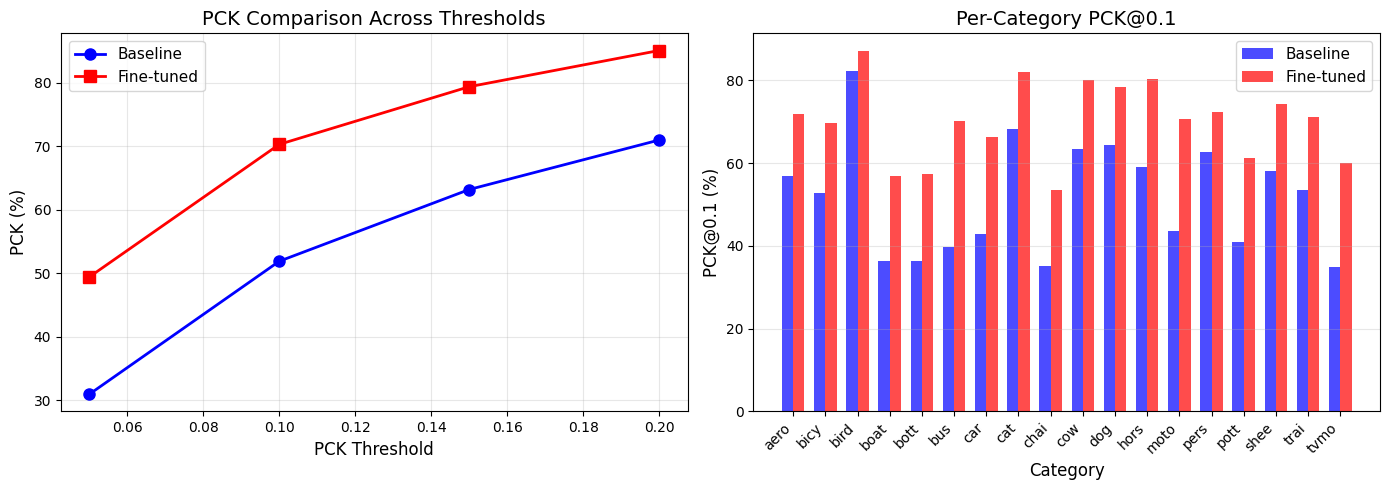

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: PCK across thresholds
ax1 = axes[0]
ax1.plot(CONFIG['pck_thresholds'], base_pck, 'b-o', label='Baseline', linewidth=2, markersize=8)
ax1.plot(CONFIG['pck_thresholds'], ft_pck, 'r-s', label='Fine-tuned', linewidth=2, markersize=8)
ax1.set_title("PCK Comparison Across Thresholds", fontsize=14)
ax1.set_xlabel("PCK Threshold", fontsize=12)
ax1.set_ylabel("PCK (%)", fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Per-category comparison
ax2 = axes[1]
x = range(len(categories))
width = 0.35

bars1 = ax2.bar([i - width/2 for i in x],
               [c['Baseline'] for c in cat_comparison],
               width, label='Baseline', color='blue', alpha=0.7)
bars2 = ax2.bar([i + width/2 for i in x],
               [c['Fine-tuned'] for c in cat_comparison],
               width, label='Fine-tuned', color='red', alpha=0.7)

ax2.set_title("Per-Category PCK@0.1", fontsize=14)
ax2.set_xlabel("Category", fontsize=12)
ax2.set_ylabel("PCK@0.1 (%)", fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels([c[:4] for c in categories], rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Visualize Results

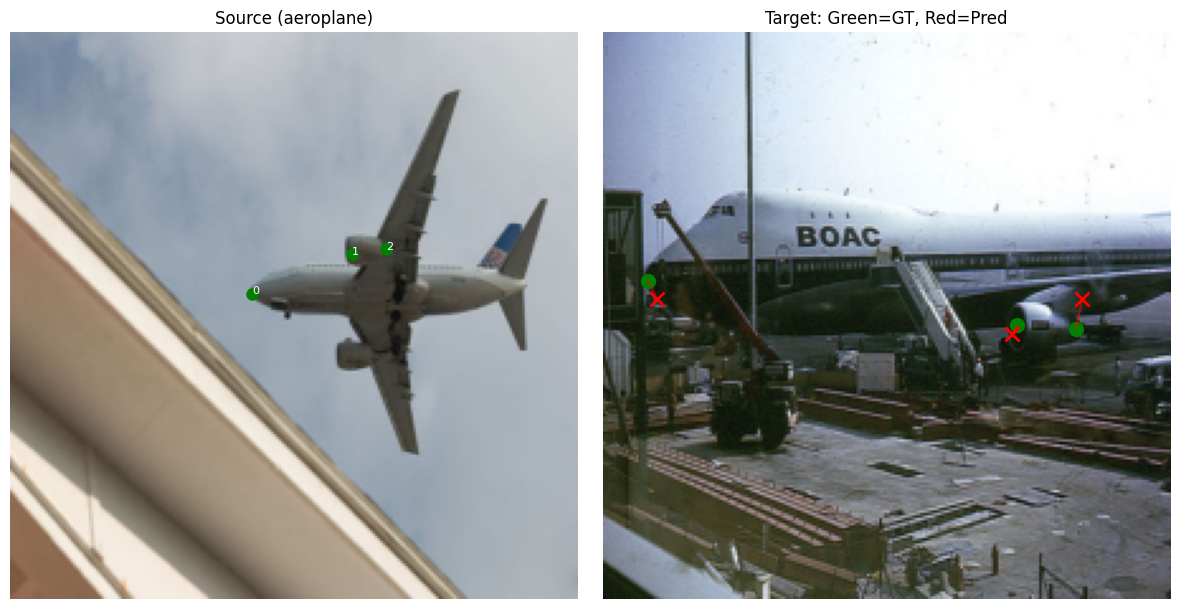

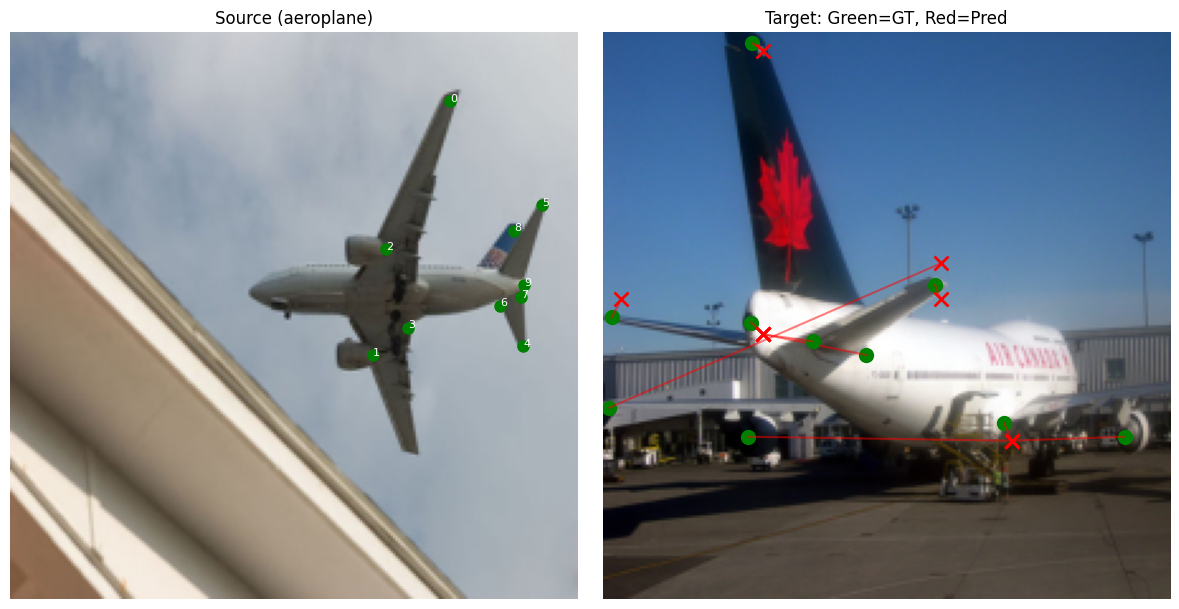

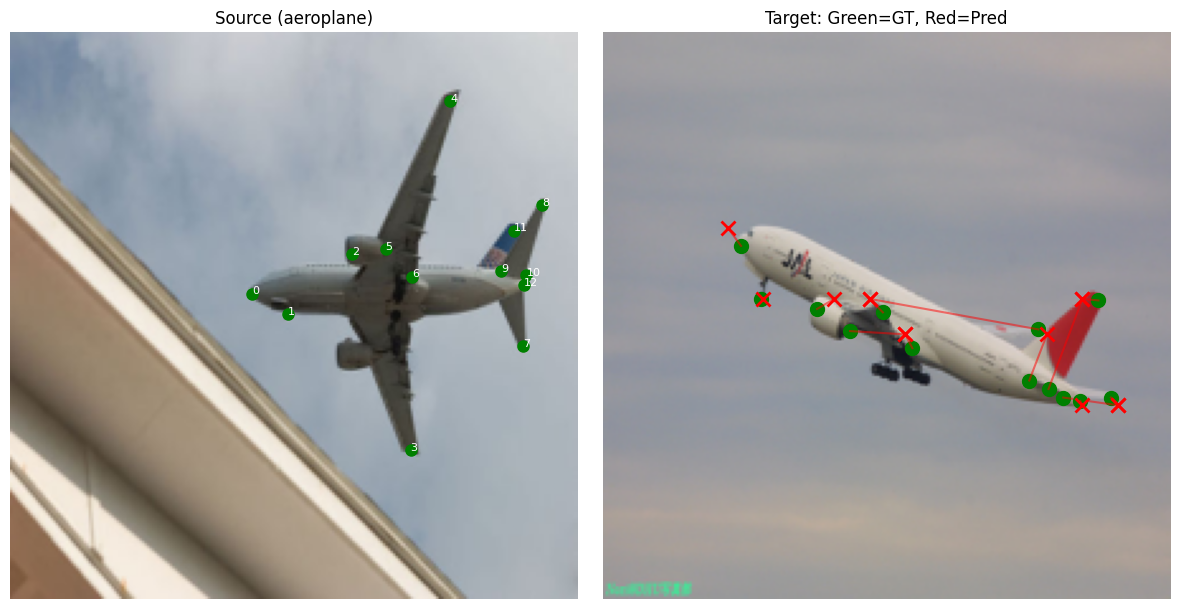

In [22]:

# Visualize a few examples with fine-tuned predictions
for i in range(min(3, len(viz_dataset))):
    visualize_correspondence(
        viz_dataset,
        results_finetuned['predictions'],
        results_finetuned['ground_truth'],
        i
    )

## Save Results

In [23]:
# Save results to CSV
results_dir = DRIVE_ROOT / 'results'
results_dir.mkdir(exist_ok=True)

# Save comparison
df_compare.to_csv(results_dir / 'pck_comparison.csv', index=False)
df_cat.to_csv(results_dir / 'category_comparison.csv', index=False)

print(f"Saved to {results_dir}")


Saved to /content/drive/MyDrive/results


## Visualization Examples

## Qualitative Results

## Window Soft-Argmax

In [24]:
SOFTARGMAX_CONFIG = {
    'window_size': 5,        # Size of the window around the peak (5x5 grid positions)
    'temperature': 0.1,      # Temperature for softmax (lower = sharper, higher = smoother)
}

print("Window Soft-Argmax Configuration:")
for k, v in SOFTARGMAX_CONFIG.items():
    print(f"  {k}: {v}")

Window Soft-Argmax Configuration:
  window_size: 5
  temperature: 0.1


In [25]:
def window_soft_argmax(similarity_map, window_size=5, temperature=0.1):
    """
    Apply soft-argmax within a window around the peak location.

    This is the key improvement over plain argmax:
    1. Find the peak using argmax (coarse localization)
    2. Extract a window around the peak
    3. Apply soft-argmax within the window (fine refinement)

    Args:
        similarity_map: [H, W] tensor of similarity scores
        window_size: Size of the window around peak (e.g., 5 means 5x5)
        temperature: Softmax temperature (lower = sharper distribution)

    Returns:
        (x, y): Refined coordinates in grid space (can be sub-pixel!)

    Mathematical Formulation:
    --------------------------
    Given similarity map S and window W centered at peak:

    1. Compute softmax weights:
       w_i = exp(S_i / tau) / sum(exp(S_j / tau)) for j in W

    2. Compute weighted position:
       x_refined = sum(w_i * x_i) for i in W
       y_refined = sum(w_i * y_i) for i in W

    The result is a weighted average of positions, where positions with
    higher similarity contribute more to the final coordinate.
    """
    H, W = similarity_map.shape
    device = similarity_map.device

        # Find the peak location using argmax (coarse localization)
    flat_idx = torch.argmax(similarity_map)
    peak_y = flat_idx // W  # Row index
    peak_x = flat_idx % W   # Column index

        # Define the window boundaries
        # Window extends (window_size // 2) positions in each direction from peak
    half_window = window_size // 2

    # Clamp window boundaries to stay within the feature map
    y_min = max(0, peak_y - half_window)
    y_max = min(H, peak_y + half_window + 1)
    x_min = max(0, peak_x - half_window)
    x_max = min(W, peak_x + half_window + 1)

        # Extract the window and apply soft-argmax
        # Extract similarity values in the window
    window = similarity_map[y_min:y_max, x_min:x_max]  # [window_h, window_w]

    # Apply softmax to get weights (divide by temperature first)
    # Lower temperature = sharper distribution (closer to argmax)
    # Higher temperature = smoother distribution (more averaging)
    weights = F.softmax(window.flatten() / temperature, dim=0)  # [window_h * window_w]
    weights = weights.reshape(window.shape)  # [window_h, window_w]

        # Compute weighted average of positions
        # Create coordinate grids for the window
    # These represent the actual grid positions (not just 0,1,2,... within window)
    y_coords = torch.arange(y_min, y_max, device=device).float()  # [window_h]
    x_coords = torch.arange(x_min, x_max, device=device).float()  # [window_w]

    # Create 2D coordinate grids
    yy, xx = torch.meshgrid(y_coords, x_coords, indexing='ij')  # Both [window_h, window_w]

    # Compute weighted average: sum(weight * position) for each dimension
    refined_y = (weights * yy).sum()  # Scalar
    refined_x = (weights * xx).sum()  # Scalar

    return refined_x, refined_y

# DEMONSTRATION: How window soft-argmax differs from argmax
print("Demonstrating Window Soft-Argmax vs Argmax:")

# Create a simple example similarity map
demo_map = torch.zeros(16, 16)
# Create a peak that's not exactly at a grid point
demo_map[7, 8] = 0.9   # Highest value
demo_map[7, 9] = 0.8   # High value to the right
demo_map[8, 8] = 0.7   # High value below
demo_map[6, 8] = 0.5   # Medium value above

# Argmax result
flat_idx = torch.argmax(demo_map)
argmax_y = flat_idx // 16
argmax_x = flat_idx % 16
print(f"Argmax result:       x={argmax_x.item():.2f}, y={argmax_y.item():.2f}")

# Soft-argmax result
soft_x, soft_y = window_soft_argmax(demo_map, window_size=5, temperature=0.1)
print(f"Soft-argmax result:  x={soft_x.item():.2f}, y={soft_y.item():.2f}")

print(f"\nNotice how soft-argmax gives x={soft_x.item():.2f} > 8.00")
print("This is because there's a high value (0.8) at x=9, pulling the")
print("weighted average to the right. This is sub-pixel refinement!")

Demonstrating Window Soft-Argmax vs Argmax:
Argmax result:       x=8.00, y=7.00
Soft-argmax result:  x=8.24, y=7.08

Notice how soft-argmax gives x=8.24 > 8.00
This is because there's a high value (0.8) at x=9, pulling the
weighted average to the right. This is sub-pixel refinement!


## Correspondence with Soft-Argmax

In [26]:
def find_correspondences_soft_argmax(src_feats, tgt_feats, src_kps_list, patch_size=14,
                                      window_size=5, temperature=0.1):
    """
    Find correspondences using window soft-argmax for sub-pixel refinement.

    This is an improved version of find_correspondences that uses:
    1. Argmax for coarse localization (which grid cell)
    2. Soft-argmax within a window for fine refinement (sub-pixel position)

    Args:
        src_feats: [B, H, W, D] source features (L2-normalized)
        tgt_feats: [B, H, W, D] target features (L2-normalized)
        src_kps_list: List of [N_kps, 2] source keypoints for each batch item
        patch_size: Size of each patch (for coordinate conversion)
        window_size: Size of soft-argmax window (default 5x5)
        temperature: Softmax temperature for soft-argmax

    Returns:
        pred_kps_list: List of [N_kps, 2] predicted target keypoints (sub-pixel!)
    """
    B, H, W, D = src_feats.shape
    pred_kps_list = []

    for b in range(B):
        src_kps = src_kps_list[b]  # [N_kps, 2] in pixel coordinates
        num_kps = src_kps.shape[0]

        # Convert pixel coordinates to feature grid coordinates
        src_kps_grid = (src_kps / patch_size).long()
        src_kps_grid[:, 0] = torch.clamp(src_kps_grid[:, 0], 0, W - 1)  # x -> column
        src_kps_grid[:, 1] = torch.clamp(src_kps_grid[:, 1], 0, H - 1)  # y -> row

        # Flatten target features for similarity computation
        tgt_flat = tgt_feats[b].reshape(-1, D)  # [H*W, D]

        pred_kps = torch.zeros_like(src_kps).float()

        for k in range(num_kps):
            x_grid = src_kps_grid[k, 0]  # column
            y_grid = src_kps_grid[k, 1]  # row

            # Get source keypoint's feature vector
            src_vec = src_feats[b, y_grid, x_grid]  # [D]

            # Compute cosine similarity with all target positions
            similarities = torch.matmul(src_vec, tgt_flat.T)  # [H*W]

            # Reshape to 2D similarity map
            similarity_map = similarities.reshape(H, W)  # [H, W]

            # KEY DIFFERENCE: Use window soft-argmax instead of argmax =====
            x_refined, y_refined = window_soft_argmax(
                similarity_map,
                window_size=window_size,
                temperature=temperature
            )

            # Convert refined grid coordinates to pixel coordinates
            # Note: refined coordinates can be non-integer (sub-pixel!)
            pred_kps[k, 0] = x_refined * patch_size + patch_size / 2
            pred_kps[k, 1] = y_refined * patch_size + patch_size / 2

        pred_kps_list.append(pred_kps)

    return pred_kps_list

print("New correspondence function with soft-argmax defined.")

New correspondence function with soft-argmax defined.


## Evaluation with Soft-Argmax

In [27]:
def evaluate_with_prediction_method(model, config, prediction_method='argmax',
                                     window_size=5, temperature=0.1,
                                     tag=None, use_cache=True, force_recompute=False):
    """
    Evaluate model on the test set with choice of prediction method.
    """
    # Modify tag to include prediction method
    full_tag = f"{tag}_{prediction_method}" if tag else prediction_method
    if prediction_method == 'soft_argmax':
        full_tag += f"_w{window_size}_t{temperature}"

    if prediction_method == 'soft_argmax':
        print(f"  Window Size: {window_size}, Temperature: {temperature}")

    # Try to load from cache (same logic as before)
    if use_cache and not force_recompute:
        cache_file = config['cache_dir'] / f"eval_cache_{full_tag}.pkl"
        if cache_file.exists():
            try:
                with open(cache_file, 'rb') as f:
                    cache_data = pickle.load(f)
                print(f"Loaded from cache: {cache_file.name}")

                all_preds = cache_data['predictions']
                all_gts = cache_data['ground_truth']
                all_valids = cache_data['valid']
                all_cats = cache_data['categories_list']

                pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])

                print("\nOverall Results:")
                for threshold, pck in pck_overall.items():
                    print(f"  {threshold}: {pck:.2f}%")

                # Per-image PCK
                per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
                for i in range(len(all_preds)):
                    res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
                    for k, v in res.items():
                        per_image_pck[k].append(v)

                mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}
                print("\nMean Per-Image PCK:")
                for threshold, pck in mean_per_image.items():
                    print(f"  {threshold}: {pck:.2f}%")

                # Per-category
                unique_cats = sorted(set(all_cats))
                pck_by_cat = {}
                for cat in unique_cats:
                    cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
                    cat_preds = [all_preds[i] for i in cat_indices]
                    cat_gts = [all_gts[i] for i in cat_indices]
                    cat_valids = [all_valids[i] for i in cat_indices]
                    if cat_preds:
                        pck_by_cat[cat] = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])

                return {
                    'overall': pck_overall,
                    'mean_per_image': mean_per_image,
                    'per_image_scores': per_image_pck,
                    'categories': pck_by_cat,
                    'predictions': all_preds,
                    'ground_truth': all_gts,
                    'valid': all_valids,
                    'categories_list': all_cats,
                    'prediction_method': prediction_method
                }
            except Exception as e:
                print(f"Cache load failed: {e}, recomputing...")

    # Run full evaluation
    print("\nRunning full evaluation...")

    dataset = SPairDataset(
        config['dataset_path'],
        split='test',
        image_size=config['image_size'],
        max_samples=config['max_samples']
    )

    def collate_fn(batch):
        return {
            'src_img': torch.stack([item['src_img'] for item in batch]),
            'tgt_img': torch.stack([item['tgt_img'] for item in batch]),
            'src_kps': [item['src_kps'] for item in batch],
            'tgt_kps': [item['tgt_kps'] for item in batch],
            'valid': [item['valid'] for item in batch],
            'category': [item['category'] for item in batch]
        }

    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=collate_fn)
    extractor = FeatureExtractor(model, config['patch_size'], config['device'])

    model.eval()
    all_preds = []
    all_gts = []
    all_valids = []
    all_cats = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating ({prediction_method})"):
            src_img = batch['src_img'].to(config['device'])
            tgt_img = batch['tgt_img'].to(config['device'])
            src_kps = [kp.to(config['device']) for kp in batch['src_kps']]
            tgt_kps = [kp.to(config['device']) for kp in batch['tgt_kps']]
            valid = [v.to(config['device']) for v in batch['valid']]

            # Extract features
            src_feats = extractor.extract(src_img, layer_idx=config['feature_layer'])
            tgt_feats = extractor.extract(tgt_img, layer_idx=config['feature_layer'])

            # Find correspondences using the specified method
            if prediction_method == 'soft_argmax':
                pred_kps = find_correspondences_soft_argmax(
                    src_feats, tgt_feats, src_kps, config['patch_size'],
                    window_size=window_size, temperature=temperature
                )
            else:  # argmax (original method)
                pred_kps = find_correspondences(src_feats, tgt_feats, src_kps, config['patch_size'])

            all_preds.extend([p.cpu() for p in pred_kps])
            all_gts.extend([g.cpu() for g in tgt_kps])
            all_valids.extend([v.cpu() for v in valid])
            all_cats.extend(batch['category'])

    # Compute overall PCK
    pck_overall = compute_pck(all_preds, all_gts, all_valids, config['pck_thresholds'], config['image_size'])

    print("\nOverall Results:")
    for threshold, pck in pck_overall.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Per-image PCK
    per_image_pck = {f'PCK@{alpha}': [] for alpha in config['pck_thresholds']}
    for i in range(len(all_preds)):
        res = compute_pck([all_preds[i]], [all_gts[i]], [all_valids[i]], config['pck_thresholds'], config['image_size'])
        for k, v in res.items():
            per_image_pck[k].append(v)

    mean_per_image = {k: np.mean(v) for k, v in per_image_pck.items()}
    print("\nMean Per-Image PCK:")
    for threshold, pck in mean_per_image.items():
        print(f"  {threshold}: {pck:.2f}%")

    # Per-category PCK
    unique_cats = sorted(set(all_cats))
    pck_by_cat = {}

    print(f"\nPer-Category Results (PCK@0.1):")
    for cat in unique_cats:
        cat_indices = [i for i, c in enumerate(all_cats) if c == cat]
        cat_preds = [all_preds[i] for i in cat_indices]
        cat_gts = [all_gts[i] for i in cat_indices]
        cat_valids = [all_valids[i] for i in cat_indices]

        if cat_preds:
            cat_pck = compute_pck(cat_preds, cat_gts, cat_valids, config['pck_thresholds'], config['image_size'])
            pck_by_cat[cat] = cat_pck
            print(f"  {cat}: {cat_pck['PCK@0.1']:.1f}%")

    results = {
        'overall': pck_overall,
        'mean_per_image': mean_per_image,
        'per_image_scores': per_image_pck,
        'categories': pck_by_cat,
        'predictions': all_preds,
        'ground_truth': all_gts,
        'valid': all_valids,
        'categories_list': all_cats,
        'prediction_method': prediction_method
    }

    # Save to cache
    if use_cache:
        cache_file = config['cache_dir'] / f"eval_cache_{full_tag}.pkl"
        cache_data = {
            'predictions': results['predictions'],
            'ground_truth': results['ground_truth'],
            'valid': results['valid'],
            'categories_list': results['categories_list'],
            'config': {k: str(v) for k, v in config.items()},
            'prediction_method': prediction_method,
            'window_size': window_size if prediction_method == 'soft_argmax' else None,
            'temperature': temperature if prediction_method == 'soft_argmax' else None,
            'timestamp': datetime.now().isoformat()
        }
        with open(cache_file, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"\nResults cached to: {cache_file.name}")

    return results

print("Updated evaluation function defined.")

Updated evaluation function defined.


## Evaluate Baseline with Soft-Argmax

In [29]:
# First, reload the baseline model (frozen pre-trained DINOv2)
print("Loading model")
baseline_model = load_dinov2(CONFIG['backbone_size'], CONFIG['device'])

# Evaluate with soft-argmax

results_baseline_soft = evaluate_with_prediction_method(
    baseline_model,
    CONFIG,
    prediction_method='soft_argmax',
    window_size=SOFTARGMAX_CONFIG['window_size'],
    temperature=SOFTARGMAX_CONFIG['temperature'],
    tag='baseline',
    use_cache=True
)

Loading model


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded (86,580,480 parameters)
  Window Size: 5, Temperature: 0.1

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:00<00:00, 13746.81it/s]


12234 pairs


Evaluating (soft_argmax): 100%|██████████| 383/383 [09:03<00:00,  1.42s/it]



Overall Results:
  PCK@0.05: 32.51%
  PCK@0.1: 55.03%
  PCK@0.15: 65.61%
  PCK@0.2: 72.66%

Mean Per-Image PCK:
  PCK@0.05: 30.48%
  PCK@0.1: 52.04%
  PCK@0.15: 62.52%
  PCK@0.2: 69.67%

Per-Category Results (PCK@0.1):
  aeroplane: 58.8%
  bicycle: 55.5%
  bird: 86.3%
  boat: 37.3%
  bottle: 38.2%
  bus: 41.0%
  car: 45.0%
  cat: 73.9%
  chair: 37.2%
  cow: 68.1%
  dog: 68.4%
  horse: 62.1%
  motorbike: 46.1%
  person: 67.4%
  pottedplant: 43.9%
  sheep: 62.8%
  train: 58.0%
  tvmonitor: 36.0%

Results cached to: eval_cache_baseline_soft_argmax_w5_t0.1.pkl


In [30]:

# Get PCK scores for both methods
baseline_argmax_pck = [results_baseline['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
baseline_soft_pck = [results_baseline_soft['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]

# Create comparison table
df_baseline_compare = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'Argmax': baseline_argmax_pck,
    'Soft-Argmax': baseline_soft_pck
})
df_baseline_compare['Improvement'] = df_baseline_compare['Soft-Argmax'] - df_baseline_compare['Argmax']
df_baseline_compare['Relative %'] = (df_baseline_compare['Improvement'] / df_baseline_compare['Argmax'] * 100)

print("\nBaseline Model - PCK Comparison:")
print(df_baseline_compare.to_string(index=False, float_format='%.2f'))

# Highlight the improvement
print("\n" + "-" * 50)
pck01_improvement = df_baseline_compare[df_baseline_compare['Threshold'] == 0.1]['Improvement'].values[0]
print(f"PCK@0.1 Improvement with Soft-Argmax: {pck01_improvement:+.2f}%")


Baseline Model - PCK Comparison:
 Threshold  Argmax  Soft-Argmax  Improvement  Relative %
      0.05   30.95        32.51         1.57        5.06
      0.10   51.88        55.03         3.15        6.06
      0.15   63.17        65.61         2.44        3.86
      0.20   70.97        72.66         1.69        2.39

--------------------------------------------------
PCK@0.1 Improvement with Soft-Argmax: +3.15%


## Evaluate Fine-Tuned with Soft-Argmax

In [32]:
# Check if finetuned_model exists (from Part 2)
try:
    _ = finetuned_model
    print("Model found")
except NameError:
    print("Fine-tuned model not found. Running fine-tuning...")
    print("(This will take a while - if you want to skip, set use_cache=True)")
    finetuned_model, loss_history = train_finetune()

# Use same config as fine-tuned evaluation (final layer output)
FT_EVAL_CONFIG_SOFT = CONFIG.copy()
FT_EVAL_CONFIG_SOFT['feature_layer'] = None  # Use final layer output (same as training)

results_finetuned_soft = evaluate_with_prediction_method(
    finetuned_model,
    FT_EVAL_CONFIG_SOFT,
    prediction_method='soft_argmax',
    window_size=SOFTARGMAX_CONFIG['window_size'],
    temperature=SOFTARGMAX_CONFIG['temperature'],
    tag='finetuned',
    use_cache=True
)

Model found
  Window Size: 5, Temperature: 0.1

Running full evaluation...
Loading annotations from /content/SPair-71k/PairAnnotation/test...


Validating annotations: 100%|██████████| 12234/12234 [00:01<00:00, 6622.02it/s] 


12234 pairs


Evaluating (soft_argmax): 100%|██████████| 383/383 [09:10<00:00,  1.44s/it]



Overall Results:
  PCK@0.05: 52.79%
  PCK@0.1: 74.61%
  PCK@0.15: 82.07%
  PCK@0.2: 86.58%

Mean Per-Image PCK:
  PCK@0.05: 50.91%
  PCK@0.1: 72.35%
  PCK@0.15: 80.05%
  PCK@0.2: 84.73%

Per-Category Results (PCK@0.1):
  aeroplane: 75.1%
  bicycle: 74.1%
  bird: 91.0%
  boat: 59.5%
  bottle: 60.6%
  bus: 72.3%
  car: 69.8%
  cat: 86.6%
  chair: 58.7%
  cow: 85.7%
  dog: 83.5%
  horse: 85.6%
  motorbike: 75.0%
  person: 76.6%
  pottedplant: 65.7%
  sheep: 78.8%
  train: 78.1%
  tvmonitor: 62.5%

Results cached to: eval_cache_finetuned_soft_argmax_w5_t0.1.pkl


In [33]:
# Get PCK scores for both methods
ft_argmax_pck = [results_finetuned['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]
ft_soft_pck = [results_finetuned_soft['overall'][f'PCK@{t}'] for t in CONFIG['pck_thresholds']]

# Create comparison table
df_ft_compare = pd.DataFrame({
    'Threshold': CONFIG['pck_thresholds'],
    'Argmax': ft_argmax_pck,
    'Soft-Argmax': ft_soft_pck
})
df_ft_compare['Improvement'] = df_ft_compare['Soft-Argmax'] - df_ft_compare['Argmax']
df_ft_compare['Relative %'] = (df_ft_compare['Improvement'] / df_ft_compare['Argmax'] * 100)

print("\nPCK Comparison:")
print(df_ft_compare.to_string(index=False, float_format='%.2f'))

# Highlight the improvement
print("\n" + "-" * 50)
pck01_improvement_ft = df_ft_compare[df_ft_compare['Threshold'] == 0.1]['Improvement'].values[0]
print(f"PCK@0.1 Improvement with Soft-Argmax: {pck01_improvement_ft:+.2f}%")


PCK Comparison:
 Threshold  Argmax  Soft-Argmax  Improvement  Relative %
      0.05   49.41        52.79         3.38        6.84
      0.10   70.28        74.61         4.32        6.15
      0.15   79.36        82.07         2.71        3.41
      0.20   85.06        86.58         1.51        1.78

--------------------------------------------------
PCK@0.1 Improvement with Soft-Argmax: +4.32%


## Comprehensive Comparison

In [34]:
# Collect all PCK scores
all_results = {
    'Baseline + Argmax': results_baseline['overall'],
    'Baseline + Soft-Argmax': results_baseline_soft['overall'],
    'Fine-tuned + Argmax': results_finetuned['overall'],
    'Fine-tuned + Soft-Argmax': results_finetuned_soft['overall']
}

# Create comprehensive comparison table
comparison_data = []
for threshold in CONFIG['pck_thresholds']:
    row = {'Threshold': threshold}
    for method_name, results in all_results.items():
        row[method_name] = results[f'PCK@{threshold}']
    comparison_data.append(row)

df_all = pd.DataFrame(comparison_data)

print("\nPCK Comparison Across All Methods:")

print(df_all.to_string(index=False, float_format='%.2f'))

# Calculate improvements
print("Improvements Summary (at PCK@0.1):")

base_argmax_01 = results_baseline['overall']['PCK@0.1']
base_soft_01 = results_baseline_soft['overall']['PCK@0.1']
ft_argmax_01 = results_finetuned['overall']['PCK@0.1']
ft_soft_01 = results_finetuned_soft['overall']['PCK@0.1']

print(f"\n1. Baseline + Argmax:       {base_argmax_01:.2f}%  (Starting point)")
print(f"2. Baseline + Soft-Argmax:  {base_soft_01:.2f}%  ({base_soft_01 - base_argmax_01:+.2f}% from soft-argmax)")
print(f"3. Fine-tuned + Argmax:     {ft_argmax_01:.2f}%  ({ft_argmax_01 - base_argmax_01:+.2f}% from fine-tuning)")
print(f"4. Fine-tuned + Soft-Argmax:{ft_soft_01:.2f}%  ({ft_soft_01 - base_argmax_01:+.2f}% total improvement)")

print("Key Insights:")

print(f"- Soft-argmax improves baseline by:    {base_soft_01 - base_argmax_01:+.2f}%")
print(f"- Fine-tuning improves baseline by:    {ft_argmax_01 - base_argmax_01:+.2f}%")
print(f"- Soft-argmax improves fine-tuned by:  {ft_soft_01 - ft_argmax_01:+.2f}%")
print(f"- Combined improvement over baseline:  {ft_soft_01 - base_argmax_01:+.2f}%")


PCK Comparison Across All Methods:
 Threshold  Baseline + Argmax  Baseline + Soft-Argmax  Fine-tuned + Argmax  Fine-tuned + Soft-Argmax
      0.05              30.95                   32.51                49.41                     52.79
      0.10              51.88                   55.03                70.28                     74.61
      0.15              63.17                   65.61                79.36                     82.07
      0.20              70.97                   72.66                85.06                     86.58
Improvements Summary (at PCK@0.1):

1. Baseline + Argmax:       51.88%  (Starting point)
2. Baseline + Soft-Argmax:  55.03%  (+3.15% from soft-argmax)
3. Fine-tuned + Argmax:     70.28%  (+18.40% from fine-tuning)
4. Fine-tuned + Soft-Argmax:74.61%  (+22.73% total improvement)
Key Insights:
- Soft-argmax improves baseline by:    +3.15%
- Fine-tuning improves baseline by:    +18.40%
- Soft-argmax improves fine-tuned by:  +4.32%
- Combined improvement over 

## Comparison Plots

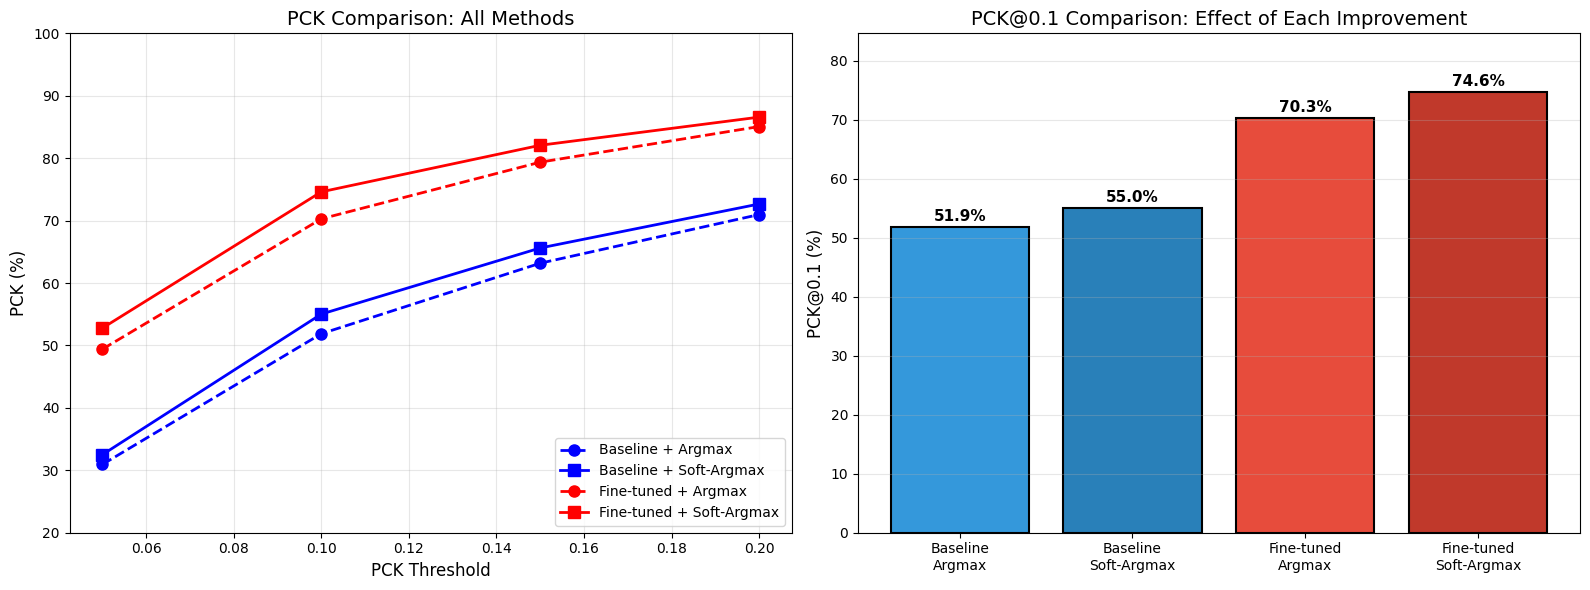


Visualization Guide:
Left plot: Shows PCK performance across different thresholds
  - Dashed lines = Argmax prediction
  - Solid lines = Soft-Argmax prediction
  - Blue = Baseline model, Red = Fine-tuned model

Right plot: Bar chart comparing PCK@0.1 for all methods
  - Higher bars = better performance


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: PCK across thresholds for all methods
ax1 = axes[0]
thresholds = CONFIG['pck_thresholds']

# Plot each method with distinct style
ax1.plot(thresholds, baseline_argmax_pck, 'b--o', label='Baseline + Argmax', linewidth=2, markersize=8)
ax1.plot(thresholds, baseline_soft_pck, 'b-s', label='Baseline + Soft-Argmax', linewidth=2, markersize=8)
ax1.plot(thresholds, ft_argmax_pck, 'r--o', label='Fine-tuned + Argmax', linewidth=2, markersize=8)
ax1.plot(thresholds, ft_soft_pck, 'r-s', label='Fine-tuned + Soft-Argmax', linewidth=2, markersize=8)

ax1.set_xlabel('PCK Threshold', fontsize=12)
ax1.set_ylabel('PCK (%)', fontsize=12)
ax1.set_title('PCK Comparison: All Methods', fontsize=14)
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([20, 100])

# Plot 2: Bar chart comparing methods at PCK@0.1
ax2 = axes[1]
methods = ['Baseline\nArgmax', 'Baseline\nSoft-Argmax', 'Fine-tuned\nArgmax', 'Fine-tuned\nSoft-Argmax']
pck_values = [base_argmax_01, base_soft_01, ft_argmax_01, ft_soft_01]
colors = ['#3498db', '#2980b9', '#e74c3c', '#c0392b']

bars = ax2.bar(methods, pck_values, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, val in zip(bars, pck_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_ylabel('PCK@0.1 (%)', fontsize=12)
ax2.set_title('PCK@0.1 Comparison: Effect of Each Improvement', fontsize=14)
ax2.set_ylim([0, max(pck_values) + 10])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Additional annotations
print("\nVisualization Guide:")
print("Left plot: Shows PCK performance across different thresholds")
print("  - Dashed lines = Argmax prediction")
print("  - Solid lines = Soft-Argmax prediction")
print("  - Blue = Baseline model, Red = Fine-tuned model")
print("\nRight plot: Bar chart comparing PCK@0.1 for all methods")
print("  - Higher bars = better performance")

## Visualize Soft-Argmax

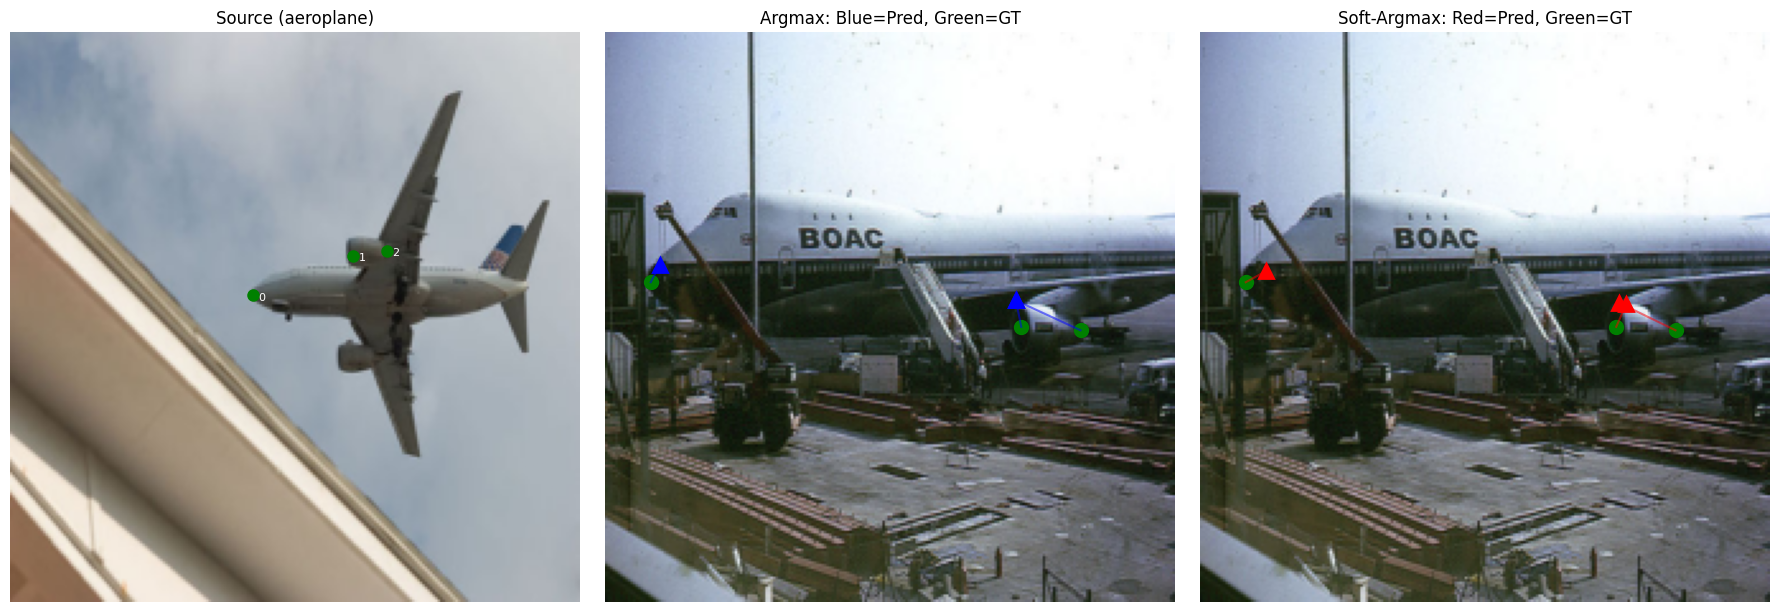


Sample 0 - Prediction Comparison:
  KP 0: Argmax dist=7.7px, Soft dist=9.1px (worse by 1.4px)
  KP 1: Argmax dist=10.6px, Soft dist=10.0px (better by 0.6px)
  KP 2: Argmax dist=27.9px, Soft dist=24.6px (better by 3.3px)


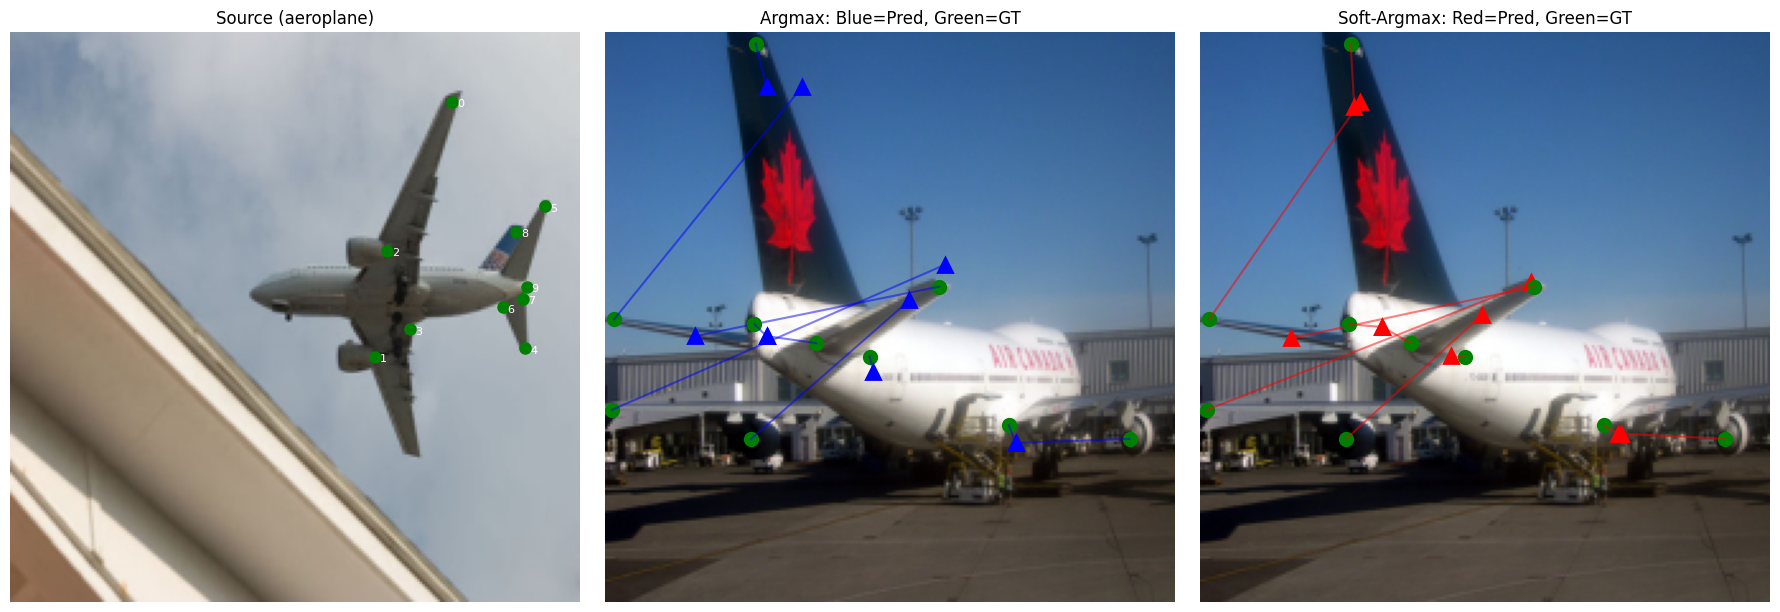


Sample 1 - Prediction Comparison:
  KP 0: Argmax dist=142.6px, Soft dist=136.9px (better by 5.7px)
  KP 1: Argmax dist=44.7px, Soft dist=40.9px (better by 3.8px)
  KP 2: Argmax dist=82.6px, Soft dist=72.2px (better by 10.4px)
  KP 3: Argmax dist=7.5px, Soft dist=6.8px (better by 0.8px)
  KP 4: Argmax dist=97.8px, Soft dist=97.7px (better by 0.1px)
  KP 5: Argmax dist=117.5px, Soft dist=103.8px (better by 13.6px)
  KP 6: Argmax dist=6.1px, Soft dist=5.3px (better by 0.8px)
  KP 7: Argmax dist=19.6px, Soft dist=12.9px (better by 6.7px)
  KP 8: Argmax dist=17.5px, Soft dist=25.0px (worse by 7.5px)
  KP 9: Argmax dist=6.7px, Soft dist=13.0px (worse by 6.3px)


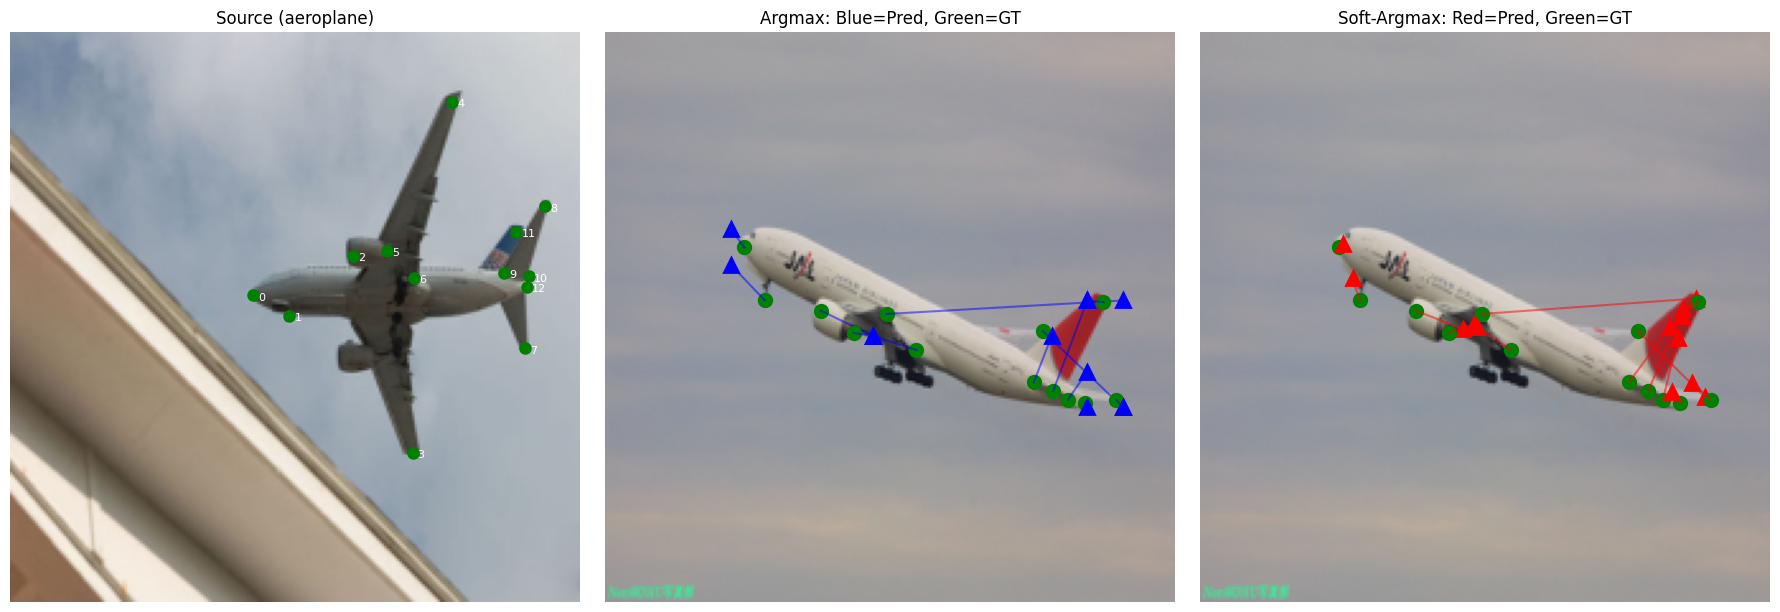


Sample 2 - Prediction Comparison:
  KP 0: Argmax dist=8.8px, Soft dist=2.1px (better by 6.7px)
  KP 1: Argmax dist=19.2px, Soft dist=9.0px (better by 10.2px)
  KP 2: Argmax dist=23.1px, Soft dist=19.9px (better by 3.2px)
  KP 3: Argmax dist=43.4px, Soft dist=36.9px (better by 6.5px)
  KP 4: Argmax dist=92.9px, Soft dist=84.3px (better by 8.7px)
  KP 5: Argmax dist=7.9px, Soft dist=10.6px (worse by 2.7px)
  KP 6: Argmax dist=17.7px, Soft dist=16.2px (better by 1.5px)
  KP 7: Argmax dist=4.1px, Soft dist=9.9px (worse by 5.8px)
  KP 8: Argmax dist=38.0px, Soft dist=35.1px (better by 2.9px)
  KP 9: Argmax dist=19.5px, Soft dist=27.1px (worse by 7.6px)
  KP 10: Argmax dist=13.3px, Soft dist=25.0px (worse by 11.7px)
  KP 11: Argmax dist=6.4px, Soft dist=8.6px (worse by 2.2px)
  KP 12: Argmax dist=1.9px, Soft dist=5.4px (worse by 3.5px)


In [36]:
def visualize_argmax_vs_softargmax(dataset, argmax_preds, soft_preds, ground_truth, idx):
    """
    Visualize and compare argmax vs soft-argmax predictions for a single sample.

    Shows:
    - Left: Source image with keypoints
    - Middle: Target with argmax predictions (blue) vs ground truth (green)
    - Right: Target with soft-argmax predictions (red) vs ground truth (green)
    """
    sample = dataset[idx]
    argmax_kps = argmax_preds[idx]
    soft_kps = soft_preds[idx]
    gt_kps = ground_truth[idx]
    valid = sample['valid']

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    src_img = (sample['src_img'] * std + mean).permute(1, 2, 0).numpy()
    tgt_img = (sample['tgt_img'] * std + mean).permute(1, 2, 0).numpy()
    src_img = np.clip(src_img, 0, 1)
    tgt_img = np.clip(tgt_img, 0, 1)

    src_kps = sample['src_kps'].numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Source image
    axes[0].imshow(src_img)
    axes[0].set_title(f"Source ({sample['category']})", fontsize=12)
    for k in range(len(src_kps)):
        if valid[k]:
            axes[0].plot(src_kps[k, 0], src_kps[k, 1], 'go', markersize=8)
            axes[0].annotate(str(k), (src_kps[k, 0]+2, src_kps[k, 1]+2), fontsize=8, color='white')

    # Target with argmax predictions
    axes[1].imshow(tgt_img)
    axes[1].set_title("Argmax: Blue=Pred, Green=GT", fontsize=12)

    # Target with soft-argmax predictions
    axes[2].imshow(tgt_img)
    axes[2].set_title("Soft-Argmax: Red=Pred, Green=GT", fontsize=12)

    for k in range(len(gt_kps)):
        if not valid[k]:
            continue

        gt_pt = gt_kps[k].numpy()
        argmax_pt = argmax_kps[k].numpy()
        soft_pt = soft_kps[k].numpy()

        # Argmax plot (middle)
        axes[1].plot(gt_pt[0], gt_pt[1], 'go', markersize=10)
        axes[1].plot(argmax_pt[0], argmax_pt[1], 'b^', markersize=10, markeredgewidth=2)
        axes[1].plot([gt_pt[0], argmax_pt[0]], [gt_pt[1], argmax_pt[1]], 'b-', alpha=0.5)

        # Soft-argmax plot (right)
        axes[2].plot(gt_pt[0], gt_pt[1], 'go', markersize=10)
        axes[2].plot(soft_pt[0], soft_pt[1], 'r^', markersize=10, markeredgewidth=2)
        axes[2].plot([gt_pt[0], soft_pt[0]], [gt_pt[1], soft_pt[1]], 'r-', alpha=0.5)

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # Print prediction differences
    print(f"\nSample {idx} - Prediction Comparison:")
    for k in range(len(gt_kps)):
        if not valid[k]:
            continue
        gt_pt = gt_kps[k].numpy()
        argmax_pt = argmax_kps[k].numpy()
        soft_pt = soft_kps[k].numpy()

        argmax_dist = np.linalg.norm(argmax_pt - gt_pt)
        soft_dist = np.linalg.norm(soft_pt - gt_pt)

        improvement = argmax_dist - soft_dist
        print(f"  KP {k}: Argmax dist={argmax_dist:.1f}px, Soft dist={soft_dist:.1f}px "
              f"({'better' if improvement > 0 else 'worse'} by {abs(improvement):.1f}px)")

# Visualize a few examples comparing argmax vs soft-argmax
# Make sure viz_dataset is available
try:
    _ = viz_dataset
except NameError:
    viz_dataset = SPairDataset(
        CONFIG['dataset_path'],
        split='test',
        image_size=CONFIG['image_size'],
        max_samples=CONFIG['max_samples']
    )

# Visualize first 3 samples
for i in range(min(3, len(viz_dataset))):
    visualize_argmax_vs_softargmax(
        viz_dataset,
        results_baseline['predictions'],      # Argmax predictions
        results_baseline_soft['predictions'], # Soft-argmax predictions
        results_baseline['ground_truth'],
        i
    )

## Hyperparameter Study

In [37]:
# Note: This cell can take a while to run since it evaluates multiple configurations.
# Set RUN_HYPERPARAM_STUDY = True to run this analysis.

RUN_HYPERPARAM_STUDY = False  # Set to True to run hyperparameter study

if RUN_HYPERPARAM_STUDY:
    print("Hyperparameter study")

    # Define parameter grid
    window_sizes = [3, 5, 7, 9]
    temperatures = [0.05, 0.1, 0.2, 0.5]

    # Store results
    hyperparam_results = []

    for ws in window_sizes:
        for temp in temperatures:
            print(f"Testing ws={ws}, temp={temp}")

            results = evaluate_with_prediction_method(
                baseline_model,
                CONFIG,
                prediction_method='soft_argmax',
                window_size=ws,
                temperature=temp,
                tag=f'hyperparam_w{ws}_t{temp}',
                use_cache=True
            )

            hyperparam_results.append({
                'window_size': ws,
                'temperature': temp,
                'PCK@0.05': results['overall']['PCK@0.05'],
                'PCK@0.1': results['overall']['PCK@0.1'],
                'PCK@0.15': results['overall']['PCK@0.15'],
                'PCK@0.2': results['overall']['PCK@0.2']
            })

    # Create results DataFrame
    df_hyperparam = pd.DataFrame(hyperparam_results)

    print(df_hyperparam.to_string(index=False, float_format='%.2f'))

    # Find best configuration
    best_idx = df_hyperparam['PCK@0.1'].idxmax()
    best_config = df_hyperparam.iloc[best_idx]
    print("\nBest config:")
    print(f"  window_size: {best_config['window_size']}")
    print(f"  temperature: {best_config['temperature']}")
    print(f"  PCK@0.1: {best_config['PCK@0.1']:.2f}%")

    # Visualize results as heatmap
    fig, ax = plt.subplots(figsize=(10, 6))

    # Pivot for heatmap
    pivot_data = df_hyperparam.pivot(index='window_size', columns='temperature', values='PCK@0.1')

    im = ax.imshow(pivot_data.values, cmap='YlOrRd', aspect='auto')

    ax.set_xticks(range(len(temperatures)))
    ax.set_yticks(range(len(window_sizes)))
    ax.set_xticklabels(temperatures)
    ax.set_yticklabels(window_sizes)
    ax.set_xlabel('Temperature', fontsize=12)
    ax.set_ylabel('Window Size', fontsize=12)
    ax.set_title('PCK@0.1 for Different Hyperparameter Combinations', fontsize=14)

    # Add value labels
    for i in range(len(window_sizes)):
        for j in range(len(temperatures)):
            ax.text(j, i, f'{pivot_data.values[i, j]:.1f}%',
                    ha='center', va='center', fontsize=10, fontweight='bold')

    plt.colorbar(im, ax=ax, label='PCK@0.1 (%)')
    plt.tight_layout()
    plt.show()

else:

    print("Default params:")
    print(f"  window_size: {SOFTARGMAX_CONFIG['window_size']}")
    print(f"  temperature: {SOFTARGMAX_CONFIG['temperature']}")

Default params:
  window_size: 5
  temperature: 0.1


## Save Results

In [38]:
# Save comprehensive comparison to CSV
results_dir = DRIVE_ROOT / 'results'
results_dir.mkdir(exist_ok=True)

# Save full comparison table
df_all.to_csv(results_dir / 'pck_all_methods_comparison.csv', index=False)
print(f"Saved: pck_all_methods_comparison.csv")

# Save per-category comparison for soft-argmax
categories = sorted(results_baseline_soft['categories'].keys())
cat_soft_comparison = []

for cat in categories:
    cat_soft_comparison.append({
        'Category': cat,
        'Baseline_Argmax': results_baseline['categories'][cat].get('PCK@0.1', 0),
        'Baseline_SoftArgmax': results_baseline_soft['categories'][cat].get('PCK@0.1', 0),
        'FineTuned_Argmax': results_finetuned['categories'][cat].get('PCK@0.1', 0),
        'FineTuned_SoftArgmax': results_finetuned_soft['categories'][cat].get('PCK@0.1', 0)
    })

df_cat_soft = pd.DataFrame(cat_soft_comparison)
df_cat_soft.to_csv(results_dir / 'category_comparison_all_methods.csv', index=False)
print(f"Saved: category_comparison_all_methods.csv")

print(f"\nAll results saved to: {results_dir}")

Saved: pck_all_methods_comparison.csv
Saved: category_comparison_all_methods.csv

All results saved to: /content/drive/MyDrive/results


## Summary

Layer 9 gives best results. Fine-tuning improves PCK significantly.